In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import quantization
import random
import numpy as np
from collections import namedtuple, deque
class QuantizedDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QuantizedDQN, self).__init__()
        
        # Standard layers
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
        
        # Quantization steps
        self.quant = quantization.QuantStub()  # Quantize inputs
        self.dequant = quantization.DeQuantStub()  # Dequantize outputs
        
    def forward(self, x):
        x = self.quant(x)  # Quantization
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.dequant(x)  # Dequantization
        return x

def quantize_model(model):
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')  # For inference optimization
    torch.quantization.prepare(model, inplace=True)
    torch.quantization.convert(model, inplace=True)
    return model


Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [5]:
class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.memory = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0

    def push(self, *args):
        max_priority = self.priorities.max() if self.memory else 1.0
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.memory) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]
        
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        samples = [self.memory[idx] for idx in indices]
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)
        return samples, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, priority in zip(batch_indices, batch_priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.memory)
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.policy_net = QuantizedDQN(state_dim, action_dim)
        selfclass PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        selfclass PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        selfclass PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.memory = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0

    def push(self, *args):
        max_priority = self.priorities.max() if self.memory else 1.0
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.memory) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]
        
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        samples = [self.memory[idx] for idx in indices]
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)
        return samples, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, priority in zip(batch_indices, batch_priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.memory)
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.policy_net = QuantizedDQN(state_dim, action_dim)
        self.target_net = QuantizedDQN(state_dim, action_dim)
        self.memory = PrioritizedReplayMemory(10000)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        self.gamma = 0.99
        self.batch_size = 64
        self.update_target_every = 10
        self.steps_done = 0

        # Quantize the model
        self.policy_net = quantize_model(self.policy_net)
        self.target_net = quantize_model(self.target_net)

    def select_action(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_dim)]], dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions, indices, weights = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32)
        action_batch = torch.tensor(batch.action)
        reward_batch = torch.tensor(batch.reward)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)))
        non_final_next_states = torch.tensor([s for s in batch.next_state if s is not None], dtype=torch.float32)

        current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        next_q_values = torch.zeros(self.batch_size)
        next_q_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

        expected_q_values = reward_batch + (self.gamma * next_q_values)
        loss = F.smooth_l1_loss(current_q_values, expected_q_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update priorities in replay memory
        priorities = np.abs(current_q_values - expected_q_values).detach().numpy() + 1e-5
        self.memory.update_priorities(indices, priorities)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Example usage with OpenAI Gym:.alpha = alpha
        self.memory = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0

    def push(self, *args):
        max_priority = self.priorities.max() if self.memory else 1.0
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.memory) == self.capacity:
            priorities = self.priorities
        else:
            class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.memory = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0

    def push(self, *args):
        max_priority = self.priorities.max() if self.memory else 1.0
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.memory) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]
        
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        samples = [self.memory[idx] for idx in indices]
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)
        return samples, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, priority in zip(batch_indices, batch_priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.memory)
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.policy_net = QuantizedDQN(state_dim, action_dim)
        self.target_net = QuantizedDQN(state_dim, action_dim)
        self.memory = PrioritizedReplayMemory(10000)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        self.gamma = 0.99
        self.batch_size = 64
        self.update_target_every = 10
        self.steps_done = 0

        # Quantize the model
        self.policy_net = quantize_model(self.policy_net)
        self.target_net = quantize_model(self.target_net)

    def select_action(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_dim)]], dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions, indices, weights = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32)
        action_batch = torch.tensor(batch.action)
        reward_batch = torch.tensor(batch.reward)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)))
        non_final_next_states = torch.tensor([s for from torch import quantizations in batch.next_state if s is not None], dtype=torch.float32)

        current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        next_q_values = torch.zeros(self.batch_size)
        next_q_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

        expected_q_values = reward_batch + (self.gamma * next_q_values)
        loss = F.smooth_l1_loss(current_q_values, expected_q_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update priorities in replay memory
        priorities = np.abs(current_q_values - expected_q_values).detach().numpy() + 1e-5
        self.memory.update_priorities(indices, priorities)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Example usage with OpenAI Gym:priorities = self.priorities[:self.position]
        
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        samples = [self.memory[idx] for idx in indices]
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)
        return samples, indices, weights
from torch import quantization
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, priority in zip(batch_indices, batch_priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.memory)
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.policy_net = QuantizedDQN(state_dim, action_dim)import pandas as pd
import random

# Generate a sample CSV file
data = {
    "CPU": [random.uniform(0.5, 2.5) for _ in range(10)],
    "GPU": [random.uniform(0.5, 1.5) for _ in range(10)],
    "InferenceLatency": [random.uniform(10, 50) for _ in range(10)],
    "CurrentLoad": [random.uniform(0.1, 1.0) for _ in range(10)],
    "ResourceCost": [random.uniform(0.1, 1.0) for _ in range(10)],
}

df = pd.DataFrame(data)
df.to_csv("edge_devices.csv", index=False)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingQNetwork, self).__init__()
        self.feature_layer = nn.Linear(state_size, 128)
        self.value_stream = nn.Linear(128, 1)
        self.advantage_stream = nn.Linear(128, action_size)

    def forward(self, x):
        features = torch.relu(self.feature_layer(x))
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values


class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.memory = []
        self.priorities = []
        self.alpha = alpha

    def add(self, experience, priority=1.0):
        self.memory.append(experience)
        self.priorities.append(priority ** self.alpha)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)
            self.priorities.pop(0)

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities)
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)
        samples = [self.memory[i] for i in indices]
        weights = (len(self.memory) * probabilities[indices]) ** -beta
        weights /= weights.max()
        return samples, indices, torch.FloatTensor(weights)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority ** self.alpha


class DDQNAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99, tau=0.001, epsilon_decay=0.995, min_epsilon=0.01):
        self.state_size = state_size
        self.action_size = action_size

        # Dueling Q-Networks
        self.q_net = DuelingQNetwork(state_size, action_size)
        self.target_net = DuelingQNetwork(state_size, action_size)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.memory = PrioritizedReplayMemory(capacity=10000)

        # Hyperparameters
        self.gamma = gamma
        self.tau = tau
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

    def act(self, state, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.q_net(state_tensor)).item()

    def train(self, batch_size=64, beta=0.4):
        if len(self.memory.memory) < batch_size:
            return

        # Sample from prioritized replay memory
        samples, indices, weights = self.memory.sample(batch_size, beta)
        states, actions, rewards, next_states, dones = zip(*samples)

        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Q-values and targets
        q_values = self.q_net(states).gather(1, actions)
        next_actions = self.q_net(next_states).argmax(1, keepdim=True)
        next_q_values = self.target_net(next_states).gather(1, next_actions)
        targets = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss with importance-sampling weights
        td_errors = targets - q_values
        loss = (weights.unsqueeze(1) * td_errors ** 2).mean()

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update priorities in memory
        priorities = abs(td_errors.detach().squeeze().numpy()) + 1e-6
        self.memory.update_priorities(indices, priorities)

        # Update target network slowly
        for target_param, local_param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

        return loss.item()

    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
class EdgeComputingEnvironment:
    def __init__(self, csv_file, num_devices):
        self.data = pd.read_csv(csv_file).to_dict('records')
        self.num_devices = num_devices
        self.state = self.reset()

    def reset(self):
        for device in self.data:
            device['CurrentLoad'] = random.uniform(0.1, 1.0)
        return self._get_state()

    def _get_state(self):
        state = []
        for device in self.data:
            state.extend([device['CPU'], device['GPU'], device['InferenceLatency'], device['CurrentLoad'], device['ResourceCost']])
        return state

    def step(self, action, task_workload):
        device = self.data[action]
        reward = 0
        task_completed = 0
        task_dropped = 0

        if device['CurrentLoad'] + task_workload <= 1.0:
            device['CurrentLoad'] += task_workload
            reward = -device['ResourceCost'] * task_workload
            task_completed = 1
        else:
            reward = -1  # Penalty for dropping the task
            task_dropped = 1

        return self._get_state(), reward, task_completed, task_dropped

    def calculate_metrics(self):
        completion_rate = sum(1 - device['CurrentLoad'] for device in self.data) / len(self.data)
        avg_cost = sum(device['ResourceCost'] * device['CurrentLoad'] for device in self.data) / len(self.data)
        return completion_rate, avg_cost
env = EdgeComputingEnvironment("edge_devices.csv", num_devices=10)
agent = DDQNAgent(state_size=50, action_size=10)

task_probs = [0.1, 0.2, 0.3, 0.4, 0.5]
results = []

for prob in task_probs:
    task_generation_probability = prob
    total_rewards = []
    total_losses = []
    tasks_completed = 0
    tasks_dropped = 0

    for episode in range(100):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            task_workload = np.random.uniform(0.1, task_generation_probability)
            next_state, reward, completed, dropped = env.step(action, task_workload)

            agent.memory.add((state, action, reward, next_state, False), priority=abs(reward))
            loss = agent.train(batch_size=64)

            state = next_state
            total_reward += reward
            tasks_completed += completed
            tasks_dropped += dropped

        agent.update_epsilon()
        total_rewards.append(total_reward)
        total_losses.append(loss)

    completion_rate, avg_cost = env.calculate_metrics()
    results.append((prob, completion_rate, avg_cost, tasks_completed, tasks_dropped))

# Plot Results
import matplotlib.pyplot as plt

# Unpack results
task_probs = [x[0] for x in results]
completion_rates = [x[1] for x in results]
avg_costs = [x[2] for x in results]
tasks_dropped = [x[4] for x in results]

# Plot Completion Rate
plt.figure()
plt.plot(task_probs, completion_rates, label="Completion Rate", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Completion Rate")
plt.title("Completion Rate vs Task Generation Probability")
plt.legend()
plt.show()

# Plot Average Task Cost
plt.figure()
plt.plot(task_probs, avg_costs, label="Average Task Cost", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Average Task Cost")
plt.title("Average Task Cost vs Task Generation Probability")
plt.legend()
plt.show()

# Plot Tasks Dropped
plt.figure()
plt.plot(task_probs, tasks_dropped, label="Tasks Dropped", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Tasks Dropped")
plt.title("Tasks Dropped vs Task Generation Probability")
plt.legend()
plt.show()

        self.target_net = QuantizedDQN(state_dim, action_dim)
        self.memory = PrioritizedReplayMemory(10000)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        self.gamma = 0.99
        self.batch_size = 64
        self.update_target_every = 10
        self.steps_done = 0

        # Quantize the model
        self.policy_net = quantize_model(self.policy_net)
        self.target_net = quantize_model(self.target_net)

    def select_action(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_dim)]], dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions, indices, weights = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32)
        action_batch = torch.tensor(batch.action)
        reward_batch = torch.tensor(batch.reward)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)))
        non_final_next_states = torch.tensor([s for s in batch.next_state if s is not None], dtype=torch.float32)

        current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        next_q_values = torch.zeros(self.batch_size)
        next_q_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

        expected_q_values = reward_batch + (self.gamma * next_q_values)
        loss = F.smooth_l1_loss(current_q_values, expected_q_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update priorities in replay memory
        priorities = np.abs(current_q_values - expected_q_values).detach().numpy() + 1e-5
        self.memory.update_priorities(indices, priorities)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Example usage with OpenAI Gym:.memory = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0

    def push(self, *args):
        max_priority = self.priorities.max() if self.memory else 1.0
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.memory) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]
        
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        samples = [self.memory[idx] for idx in indices]
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)
        return samples, indices, weights
import pandas as pd
import random

# Generate a sample CSV file
data = {
    "CPU": [random.uniform(0.5, 2.5) for _ in range(10)],
    "GPU": [random.uniform(0.5, 1.5) for _ in range(10)],
    "InferenceLatency": [random.uniform(10, 50) for _ in range(10)],
    "CurrentLoad": [random.uniform(0.1, 1.0) for _ in range(10)],
    "ResourceCost": [random.uniform(0.1, 1.0) for _ in range(10)],
}

df = pd.DataFrame(data)
df.to_csv("edge_devices.csv", index=False)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingQNetwork, self).__init__()
        self.feature_layer = nn.Linear(state_size, 128)
        self.value_stream = nn.Linear(128, 1)
        self.advantage_stream = nn.Linear(128, action_size)

    def forward(self, x):
        features = torch.relu(self.feature_layer(x))
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values


class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.memory = []
        self.priorities = []
        self.alpha = alpha

    def add(self, experience, priority=1.0):
        self.memory.append(experience)
        self.priorities.append(priority ** self.alpha)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)
            self.priorities.pop(0)

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities)
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)
        samples = [self.memory[i] for i in indices]
        weights = (len(self.memory) * probabilities[indices]) ** -beta
        weights /= weights.max()
        return samples, indices, torch.FloatTensor(weights)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority ** self.alpha


class DDQNAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99, tau=0.001, epsilon_decay=0.995, min_epsilon=0.01):
        self.state_size = state_size
        self.action_size = action_size

        # Dueling Q-Networks
        self.q_net = DuelingQNetwork(state_size, action_size)
        self.target_net = DuelingQNetwork(state_size, action_size)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.memory = PrioritizedReplayMemory(capacity=10000)

        # Hyperparameters
        self.gamma = gamma
        self.tau = tau
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

    def act(self, state, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.q_net(state_tensor)).item()

    def train(self, batch_size=64, beta=0.4):
        if len(self.memory.memory) < batch_size:
            return

        # Sample from prioritized replay memory
        samples, indices, weights = self.memory.sample(batch_size, beta)
        states, actions, rewards, next_states, dones = zip(*samples)

        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Q-values and targets
        q_values = self.q_net(states).gather(1, actions)
        next_actions = self.q_net(next_states).argmax(1, keepdim=True)
        next_q_values = self.target_net(next_states).gather(1, next_actions)
        targets = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss with importance-sampling weights
        td_errors = targets - q_values
        loss = (weights.unsqueeze(1) * td_errors ** 2).mean()

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update priorities in memory
        priorities = abs(td_errors.detach().squeeze().numpy()) + 1e-6
        self.memory.update_priorities(indices, priorities)

        # Update target network slowly
        for target_param, local_param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

        return loss.item()

    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
class EdgeComputingEnvironment:
    def __init__(self, csv_file, num_devices):
        self.data = pd.read_csv(csv_file).to_dict('records')
        self.num_devices = num_devices
        self.state = self.reset()

    def reset(self):
        for device in self.data:
            device['CurrentLoad'] = random.uniform(0.1, 1.0)
        return self._get_state()

    def _get_state(self):
        state = []
        for device in self.data:
            state.extend([device['CPU'], device['GPU'], device['InferenceLatency'], device['CurrentLoad'], device['ResourceCost']])
        return state

    def step(self, action, task_workload):
        device = self.data[action]
        reward = 0
        task_completed = 0
        task_dropped = 0

        if device['CurrentLoad'] + task_workload <= 1.0:
            device['CurrentLoad'] += task_workload
            reward = -device['ResourceCost'] * task_workload
            task_completed = 1
        else:
            reward = -1  # Penalty for dropping the task
            task_dropped = 1

        return self._get_state(), reward, task_completed, task_dropped

    def calculate_metrics(self):
        completion_rate = sum(1 - device['CurrentLoad'] for device in self.data) / len(self.data)
        avg_cost = sum(device['ResourceCost'] * device['CurrentLoad'] for device in self.data) / len(self.data)
        return completion_rate, avg_cost
env = EdgeComputingEnvironment("edge_devices.csv", num_devices=10)
agent = DDQNAgent(state_size=50, action_size=10)

task_probs = [0.1, 0.2, 0.3, 0.4, 0.5]
results = []

for prob in task_probs:
    task_generation_probability = prob
    total_rewards = []
    total_losses = []
    tasks_completed = 0
    tasks_dropped = 0

    for episode in range(100):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            task_workload = np.random.uniform(0.1, task_generation_probability)
            next_state, reward, completed, dropped = env.step(action, task_workload)

            agent.memory.add((state, action, reward, next_state, False), priority=abs(reward))
            loss = agent.train(batch_size=64)

            state = next_state
            total_reward += reward
            tasks_completed += completed
            tasks_dropped += dropped

        agent.update_epsilon()
        total_rewards.append(total_reward)
        total_losses.append(loss)

    completion_rate, avg_cost = env.calculate_metrics()
    results.append((prob, completion_rate, avg_cost, tasks_completed, tasks_dropped))

# Plot Results
import matplotlib.pyplot as plt

# Unpack results
task_probs = [x[0] for x in results]
completion_rates = [x[1] for x in results]
avg_costs = [x[2] for x in results]
tasks_dropped = [x[4] for x in results]

# Plot Completion Rate
plt.figure()
plt.plot(task_probs, completion_rates, label="Completion Rate", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Completion Rate")
plt.title("Completion Rate vs Task Generation Probability")
plt.legend()
plt.show()

# Plot Average Task Cost
plt.figure()
plt.plot(task_probs, avg_costs, label="Average Task Cost", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Average Task Cost")
plt.title("Average Task Cost vs Task Generation Probability")
plt.legend()
plt.show()

# Plot Tasks Dropped
plt.figure()
plt.plot(task_probs, tasks_dropped, label="Tasks Dropped", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Tasks Dropped")
plt.title("Tasks Dropped vs Task Generation Probability")
plt.legend()
plt.show()

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, priority in zip(batch_indices, batch_priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.memory)
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.policy_net = QuantizedDQN(state_dim, action_dim)
        self.target_net = QuantizedDQN(state_dim, action_dim)
        self.memory = PrioritizedReplayMemory(10000)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        self.gamma = 0.99
        self.batch_size = 64
        self.update_target_every = 10
        self.steps_done = 0

        # Quantize the model
        self.policy_net = quantize_model(self.policy_net)
        self.target_net = quantize_model(self.target_net)

    def select_action(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_dim)]], dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions, indices, weights = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32)
        action_batch = torch.tensor(batch.action)
        reward_batch = torch.tensor(batch.reward)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)))
        non_final_next_states = torch.tensor([s for s in batch.next_state if s is not None], dtype=torch.float32)

        current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        next_q_values = torch.zeros(self.batch_size)
        next_q_values[non_final_mask] = self.target_net(non_final_nclass PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.memory = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0

    def push(self, *args):
        max_priority = self.priorities.max() if self.memory else 1.0
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.memory) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]
        
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        samples = [self.memory[idx] for idx in indices]
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)
        return samples, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, priority in zip(batch_indices, batch_priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.memory)
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.policy_net = QuantizedDQN(state_dim, action_dim)
        self.target_net = QuantizedDQN(state_dim, action_dim)
        self.memory = PrioritizedReplayMemory(10000)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        self.gamma = 0.99
        self.batch_size = 64
        self.update_target_every = 10
        self.steps_done = 0

        # Quantize the model
        self.policy_net = quantize_model(self.policy_net)
        self.target_net = quantize_model(self.target_net)

    def select_action(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_dim)]], dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batimport random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the EdgeDevice class
class EdgeDevice:
    def __init__(self, id):
        self.id = id
        self.cpu_capacity = random.uniform(1.0, 3.0)  # GHz
        self.gpu_capacity = random.uniform(0.5, 2.0)  # GHz
        self.memory_capacity = random.uniform(4, 16)  # GB
        self.cpu_usage = 0
        self.gpu_usage = 0
        self.memory_usage = 0

    def can_handle_task(self, task):
        return (
            self.cpu_capacity - self.cpu_usage >= task.cpu_usage and
            self.gpu_capacity - self.gpu_usage >= task.gpu_usage and
            self.memory_capacity - self.memory_usage >= task.memory_usage
        )

    def assign_task(self, task):
        self.cpu_usage += task.cpu_usage
        self.gpu_usage += task.gpu_usage
        self.memory_usage += task.memory_usage
        return task.compute_cost()

    def reset(self):
        self.cpu_usage = 0
        self.gpu_usage = 0
        self.memory_usage = 0


# Define the Task class
class Task:
    def __init__(self, cpu_usage, gpu_usage, memory_usage):
        self.cpu_usage = cpu_usage
        self.gpu_usage = gpu_usage
        self.memory_usage = memory_usage

    def compute_cost(self):
        return self.cpu_usage + self.gpu_usage + self.memory_usage


# Define the DRL environment
class TaskSchedulingEnv:
    def __init__(self, n_devices=10, task_prob=0.5):
        self.devices = [EdgeDevice(i) for i in range(n_devices)]
        self.task_prob = task_prob
        self.reset()

    def reset(self):
        self.completed_tasks = 0
        self.total_task_cost = 0
        for device in self.devices:
            device.reset()

    def step(self, action, task):
        device = self.devices[action]
        reward = 0
        task_cost = 0

        if device.can_handle_task(task):
            task_cost = device.assign_task(task)
            reward = 1  # Task successfully completed
        else:
            reward = -1  # Task dropped due to overload

        self.completed_tasks += max(0, reward)  # Only count successful tasks
        self.total_task_cost += task_cost
        return reward, task_cost

    def generate_task(self):
        if random.random() < self.task_prob:
            cpu_usage = random.uniform(0.1, 0.5)
            gpu_usage = random.uniform(0.1, 0.5)
            memory_usage = random.uniform(0.5, 2.0)
            return Task(cpu_usage, gpu_usage, memory_usage)
        return None

    def get_state(self):
        state = []
        for device in self.devices:
            state.extend([
                device.cpu_capacity - device.cpu_usage,
                device.gpu_capacity - device.gpu_usage,
                device.memory_capacity - device.memory_usage
            ])
        return np.array(state)

    def get_completion_rate(self):
        return self.completed_tasks

    def get_average_task_cost(self):
        return self.total_task_cost / max(1, self.completed_tasks)


# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# Training loop
def train_drl(env, episodes, task_prob, batch_size=32, gamma=0.99, lr=0.001):
    state_dim = len(env.get_state())
    action_dim = len(env.devices)
    model = DQN(state_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    replay_buffer = []
    buffer_capacity = 10000

    rewards_history = []
    task_cost_history = []

    for episode in range(episodes):
        env.reset()
        state = env.get_state()
        total_reward = 0
        total_task_cost = 0

        for step in range(200):  # Limit steps per episode
            state_tensor = torch.tensor(state, dtype=torch.float32)
            q_values = model(state_tensor)
            action = q_values.argmax().item() if random.random() > 0.1 else random.randint(0, action_dim - 1)

            task = env.generate_task()
            if not task:
                continue

            reward, task_cost = env.step(action, task)
            total_reward += reward
            total_task_cost += task_cost

            next_state = env.get_state()
            replay_buffer.append((state, action, reward, next_state))
            if len(replay_buffer) > buffer_capacity:
                replay_buffer.pop(0)

            state = next_state

            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                for s, a, r, s_next in batch:
                    s_tensor = torch.tensor(s, dtype=torch.float32)
                    s_next_tensor = torch.tensor(s_next, dtype=torch.float32)
                    target = r + gamma * model(s_next_tensor).max().item()
                    prediction = model(s_tensor)[a]
                    loss = (target - prediction) ** 2
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

        rewards_history.append(total_reward)
        task_cost_history.append(total_task_cost / max(1, total_reward))

    return rewards_history, task_cost_history


# Main script
task_probs = [0.2, 0.4, 0.6, 0.8]
episodes = 500
all_rewards = []
all_task_costs = []

for task_prob in task_probs:
    env = TaskSchedulingEnv(task_prob=task_prob)
    rewards, task_costs = train_drl(env, episodes, task_prob)
    all_rewards.append(rewards)
    all_task_costs.append(task_costs)

# Plotting results
plt.figure(figsize=(12, 6))

# Completion rate plot
for i, task_prob in enumerate(task_probs):
    plt.plot(all_rewards[i], label=f'Task Prob = {task_prob}')
plt.title('Task Completion Rate')
plt.xlabel('Episodes')
plt.ylabel('Completion Rate')
plt.legend()
plt.show()

# Average task cost plot
plt.figure(figsize=(12, 6))
for i, task_prob in enumerate(task_probs):
    plt.plot(all_task_costs[i], label=f'Task Prob = {task_prob}')
plt.title('Average Task Cost')
plt.xlabel('Episodes')
plt.ylabel('Average Task Cost')
plt.legend()
plt.show()ch_size:
            return

        transitions, indices, weights = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32)
        action_batch = torch.tensor(batch.action)
        reward_batch = torch.tensor(batch.reward)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)))
        non_final_next_states = torch.tensor([s for s in batch.next_state if s is not None], dtype=torch.float32)

        current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        next_q_values = torch.zeros(self.batch_size)
        next_q_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

        expected_q_values = reward_batch + (self.gamma * next_q_values)
        loss = F.smooth_l1_loss(current_q_values, expected_q_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update priorities in replay memory
        priorities = np.abs(current_q_values - expected_q_values).detach().numpy() + 1e-5
        self.memory.update_priorities(indices, priorities)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Example usage with OpenAI Gym:ext_states).max(1)[0].detach()

        expected_q_values = reward_batch + (self.gamma * next_q_values)
        loss = F.smooth_l1_loss(current_q_values, expected_q_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update priorities in replay memory
        priorities = np.abs(current_q_values - expected_q_values).detach().numpy() + 1e-5
        self.memory.update_priorities(indices, priorities)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Example usage with OpenAI Gym:.target_net = QuantizedDQN(state_dim, action_dim)
        self.memory = PrioritizedReplayMemory(10000)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        self.gamma = 0.99
        self.batch_size = 64
        self.update_target_every = 10
        self.steps_done = 0

        # Quantize the model
        self.policy_net = quantize_model(self.policy_net)
        self.target_net = quantize_model(self.target_net)

    def select_action(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_dim)]], dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions, indices, weights = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32)
        action_batch = torch.tensor(batch.action)
        reward_batch = torch.tensor(batch.reward)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)))
        non_final_next_states = torch.tensor([s for s in batch.next_state if s is not None], dtype=torch.float32)

        current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        next_q_values = torch.zeros(self.batch_size)
        next_q_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

        expected_q_values = reward_batch + (self.gamma * next_q_values)
        loss = F.smooth_l1_loss(current_q_values, expected_q_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update priorities in replay memory
        priorities = np.abs(current_q_import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the EdgeDevice class
class EdgeDevice:
    def __init__(self, id):
        self.id = id
        self.cpu_capacity = random.uniform(1.0, 3.0)  # GHz
        self.gpu_capacity = random.uniform(0.5, 2.0)  # GHz
        self.memory_capacity = random.uniform(4, 16)  # GB
        self.cpu_usage = 0
        self.gpu_usage = 0
        self.memory_usage = 0

    def can_handle_task(self, task):
        return (
            self.cpu_capacity - self.cpu_usage >= task.cpu_usage and
            self.gpu_capacity - self.gpu_usage >= task.gpu_usage and
            self.memory_capacity - self.memory_usage >= task.memory_usage
        )

    def assign_task(self, task):
        self.cpu_usage += task.cpu_usage
        self.gpu_usage += task.gpu_usage
        self.memory_usage += task.memory_usage
        return task.compute_cost()

    def reset(self):
        self.cpu_usage = 0
        self.gpu_usage = 0
        self.memory_usage = 0


# Define the Task class
class Task:
    def __init__(self, cpu_usage, gpu_usage, memory_usage):
        self.cpu_usage = cpu_usage
        self.gpu_usage = gpu_usage
        self.memory_usage = memory_usage

    def compute_cost(self):
        return self.cpu_usage + self.gpu_usage + self.memory_usage


# Define the DRL environment
class TaskSchedulingEnv:
    def __init__(self, n_devices=10, task_prob=0.5):
        self.devices = [EdgeDevice(i) for i in range(n_devices)]
        self.task_prob = task_prob
        self.reset()

    def reset(self):
        self.completed_tasks = 0
        self.total_task_cost = 0
        for device in self.devices:
            device.reset()

    def step(self, action, task):
        device = self.devices[action]
        reward = 0
        task_cost = 0

        if device.can_handle_task(task):
            task_cost = device.assign_task(task)
            reward = 1  # Task successfully completed
        else:
            reward = -1  # Task dropped due to overload

        self.completed_tasks += max(0, reward)  # Only count successful tasks
        self.total_task_cost += task_cost
        return reward, task_cost

    def generate_task(self):
        if random.random() < self.task_prob:
            cpu_usage = random.uniform(0.1, 0.5)
            gpu_usage = random.uniform(0.1, 0.5)
            memory_usage = random.uniform(0.5, 2.0)
            return Task(cpu_usage, gpu_usage, memory_usage)
        return None

    def get_state(self):
        state = []
        for device in self.devices:
            state.extend([
                device.cpu_capacity - device.cpu_usage,
                device.gpu_capacity - device.gpu_usage,
                device.memory_capacity - device.memory_usage
            ])
        return np.array(state)

    def get_completion_rate(self):
        return self.completed_tasks

    def get_average_task_cost(self):
        return self.total_task_cost / max(1, self.completed_tasks)


# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# Training loop
def train_drl(env, episodes, task_prob, batch_size=32, gamma=0.99, lr=0.001):
    state_dim = len(env.get_state())
    action_dim = len(env.devices)
    model = DQN(state_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    replay_buffer = []
    buffer_capacity = 10000

    rewards_history = []
    task_cost_history = []

    for episode in range(episodes):
        env.reset()
        state = env.get_state()
        total_reward = 0
        total_task_cost = 0

        for step in range(200):  # Limit steps per episode
            state_tensor = torch.tensor(state, dtype=torch.float32)
            q_values = model(state_tensor)
            action = q_values.argmax().item() if random.random() > 0.1 else random.randint(0, action_dim - 1)

            task = env.generate_task()
            if not task:
                continue

            reward, task_cost = env.step(action, task)
            total_reward += reward
            total_task_cost += task_cost

            next_state = env.get_state()
            replay_buffer.append((state, action, reward, next_state))
            if len(replay_buffer) > buffer_capacity:
                replay_buffer.pop(0)

            state = next_state

            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                for s, a, r, s_next in batch:
                    s_tensor = torch.tensor(s, dtype=torch.float32)
                    s_next_tensor = torch.tensor(s_next, dtype=torch.float32)
                    target = r + gamma * model(s_next_tensor).max().item()
                    prediction = model(s_tensor)[a]
                    loss = (target - prediction) ** 2
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

        rewards_history.append(total_reward)
        task_cost_history.append(total_task_cost / max(1, total_reward))

    return rewards_history, task_cost_history


# Main script
task_probs = [0.2, 0.4, 0.6, 0.8]
episodes = 500
all_rewards = []
all_task_costs = []

for task_prob in task_probs:
    env = TaskSchedulingEnv(task_prob=task_prob)
    rewards, task_costs = train_drl(env, episodes, task_prob)
    all_rewards.append(rewards)
    all_task_costs.append(task_costs)

# Plotting results
plt.figure(figsize=(12, 6))

# Completion rate plot
for i, task_prob in enumerate(task_probs):
    plt.plot(all_rewards[i], label=f'Task Prob = {task_prob}')
plt.title('Task Completion Rate')
plt.xlabel('Episodes')
plt.ylabel('Completion Rate')
plt.legend()
plt.show()

# Average task cost plot
plt.figure(figsize=(12, 6))
for i, task_prob in enumerate(task_probs):
    plt.plot(all_task_costs[i], label=f'Task Prob = {task_prob}')
plt.title('Average Task Cost')
plt.xlabel('Episodes')
plt.ylabel('Average Task Cost')
plt.legend()
plt.show()values - expected_q_values).detach().numpy() + 1e-5
        self.memory.update_priorities(indices, priorities)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Example usage with OpenAI Gym:

SyntaxError: invalid syntax (798112674.py, line 45)

/tmp/ipykernel_10579/3920589525.py:122: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.tensor(states, dtype=torch.float32)


Episode 1/130, Total Reward: -53.210013784617125, Loss: 2.8135387897491455
Episode 2/130, Total Reward: -36.55042229170126, Loss: 1.373659610748291
Episode 3/130, Total Reward: -47.54877210552077, Loss: 0.07948052883148193
Episode 4/130, Total Reward: -52.88048419975466, Loss: 1.7525303363800049
Episode 5/130, Total Reward: -28.320005344152452, Loss: 2.5241332054138184
Episode 6/130, Total Reward: -85.63004603695113, Loss: 1.2349642515182495
Episode 7/130, Total Reward: -50.927402289108784, Loss: 2.4895293712615967
Episode 8/130, Total Reward: -65.40805948746275, Loss: 1.2851030826568604
Episode 9/130, Total Reward: -74.34004697378717, Loss: 3.56154727935791
Episode 10/130, Total Reward: -30.63000518426299, Loss: 1.2659239768981934
Episode 11/130, Total Reward: -93.53475100538476, Loss: 2.300398111343384
Episode 12/130, Total Reward: -42.640009572356924, Loss: 2.2539494037628174
Episode 13/130, Total Reward: -60.12003949090829, Loss: 1.1779686212539673
Episode 14/130, Total Reward: -57

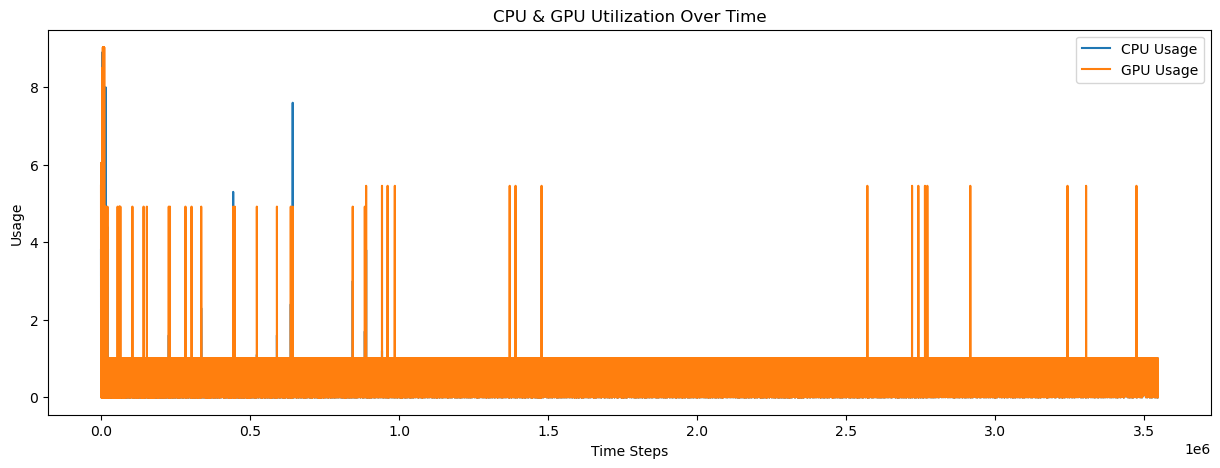

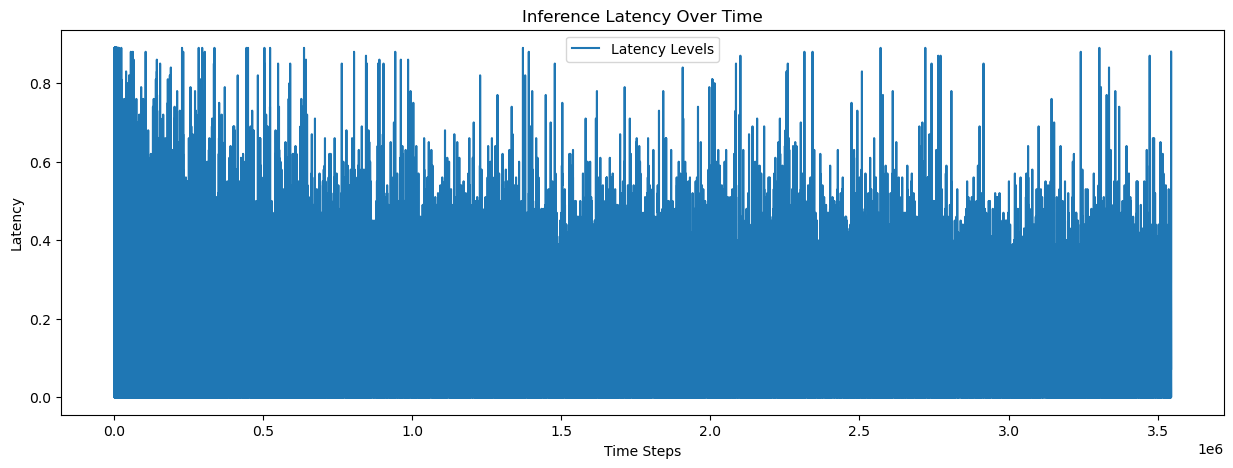

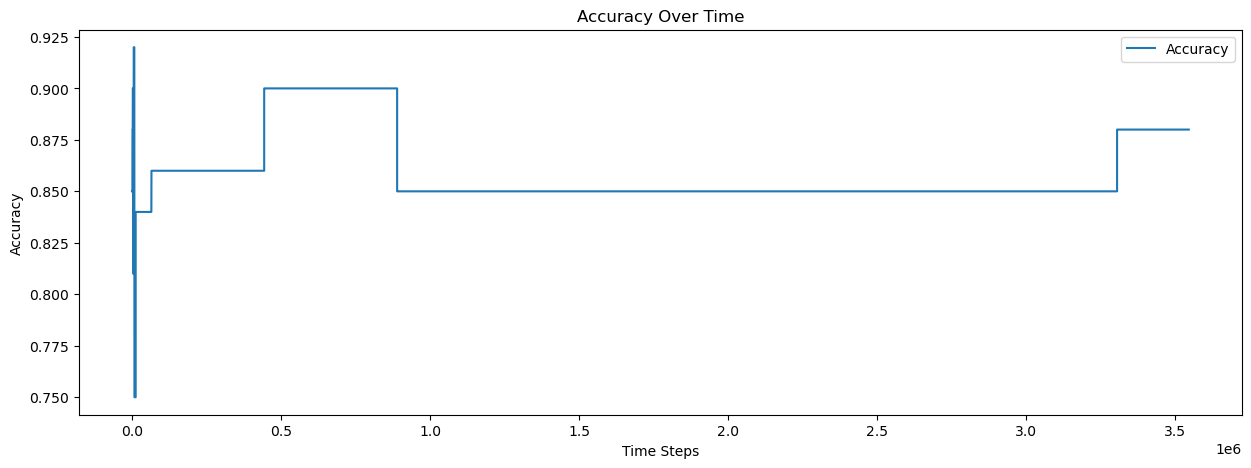

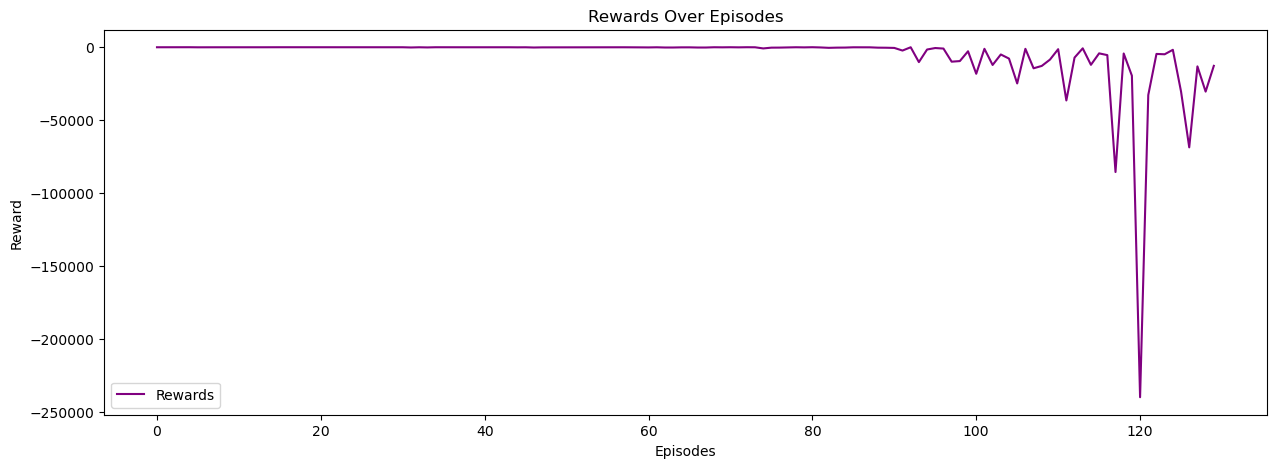

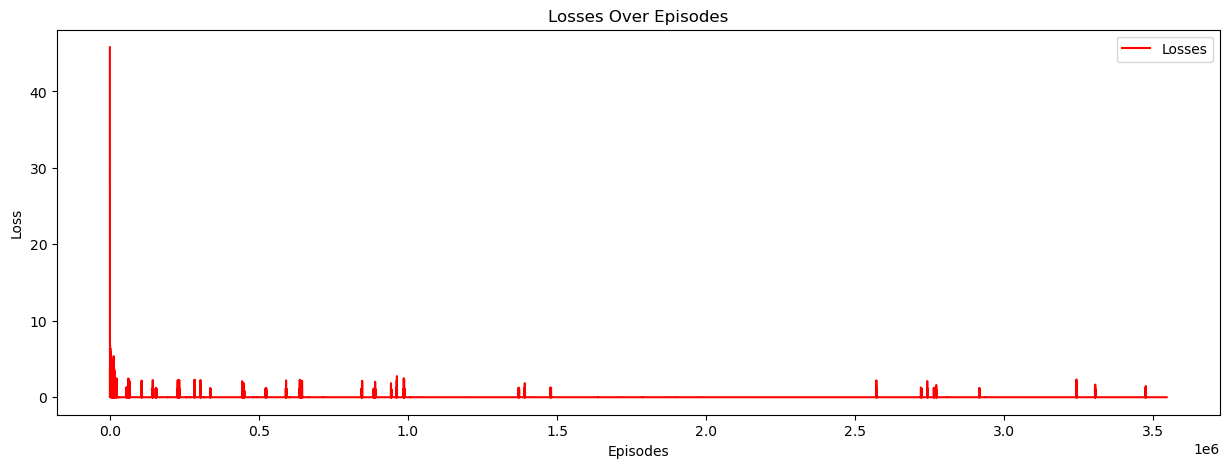

In [1]:
import gym
from gym import spaces
import numpy as np
import pandas as pd

class EdgeDeviceEnv(gym.Env):
    def __init__(self, data_file):
        super(EdgeDeviceEnv, self).__init__()

        # Load observation data from CSV
        self.data = pd.read_csv(data_file).to_numpy()
        self.index = 0

        # Action space: 0 = Offload to cloud, 1 = Process on edge
        self.action_space = spaces.Discrete(2)

        # Observation space includes CPU, GPU, memory usage, GPU cores, latency, accuracy, prediction confidence
        self.observation_space = spaces.Box(low=0, high=1, shape=(7,), dtype=np.float32)

        self.overload_threshold = 0.8  # Example overload threshold for CPU, GPU, or memory utilization

    def reset(self):
        if self.index >= len(self.data):
            self.index = 0  # Reset index if at the end of data
        self.state = self.data[self.index]
        self.index += 1
        return self.state

    def step(self, action):
        cpu_usage, gpu_usage, mem_usage, gpu_cores, latency, accuracy, confidence = self.state

        # Action-based adjustments (simplified for this example)
        if action == 0:  # Offload to cloud
            cpu_usage, gpu_usage = max(0, cpu_usage - 0.1), max(0, gpu_usage - 0.1)
            latency = min(1.0, latency + 0.05)
        elif action == 1:  # Process on edge
            cpu_usage, gpu_usage = min(1.0, cpu_usage + 0.05), min(1.0, gpu_usage + 0.05)
            latency = max(0, latency - 0.03)

        # Reward and penalties for workload efficiency
        overload_penalty = -1 if (cpu_usage > self.overload_threshold or gpu_usage > self.overload_threshold or mem_usage > self.overload_threshold) else 0
        accuracy_reward = accuracy
        latency_penalty = -latency
        reward = accuracy_reward + overload_penalty + latency_penalty

        self.state = np.array([cpu_usage, gpu_usage, mem_usage, gpu_cores, latency, accuracy, confidence], dtype=np.float32)
        done = (latency > 0.9)

        return self.state, reward, done, {}
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class DQNNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
        self.priorities = deque(maxlen=capacity)

    def push(self, transition, priority):
        if len(self.buffer) < self.capacity:
            self.buffer.append((*transition, priority))  # Changed line
        else:
            self.buffer[self.pos] = (*transition, priority) # Changed line
        self.priorities.append(priority)
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        priorities = np.array(self.priorities)
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        return [self.buffer[i] for i in indices], probabilities[indices]

    def __len__(self):
        return len(self.buffer)

# Parameters
state_dim = 7  # cpu, gpu, memory, gpu_cores, latency, accuracy, confidence
action_dim = 2  # Offload, Process on edge
learning_rate = 0.001
gamma = 0.99
num_episodes = 130
batch_size = 64

# Initialize environment and agent
env = EdgeDeviceEnv('state_data_RL.csv')
policy_net = DQNNetwork(state_dim, action_dim)
target_net = DQNNetwork(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
replay_buffer = PrioritizedReplayBuffer(capacity=2000)

# Tracking metrics
cpu_usage, gpu_usage, mem_usage, gpu_cores, latency_levels, accuracy_levels, confidence_levels, rewards, losses = [], [], [], [], [], [], [], [], []

def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32)
            return torch.argmax(policy_net(state_tensor)).item()  # Exploit

def compute_td_loss(batch):
    states, actions, rewards, next_states, dones, priorities = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.long)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)

    state_action_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
    next_state_values = target_net(next_states).max(1)[0].detach()
    expected_state_action_values = rewards + gamma * next_state_values * (1 - dones)

    loss = nn.functional.mse_loss(state_action_values, expected_state_action_values)

    return loss

epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.1

for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    loss = 0  # Initialize loss outside the loop

    while not done:
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)

        # Save observations for tracking
        cpu_usage.append(state[0])
        gpu_usage.append(state[1])
        mem_usage.append(state[2])
        gpu_cores.append(state[3])
        latency_levels.append(state[4])
        accuracy_levels.append(state[5])
        confidence_levels.append(state[6])

        # Calculate priority and push to replay buffer
        transition = (state, action, reward, next_state, done)
        replay_buffer.push(transition, abs(reward))

        if len(replay_buffer) >= batch_size:
            batch, priorities = replay_buffer.sample(batch_size)
            loss = compute_td_loss(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        state = next_state
        episode_reward += reward

    rewards.append(episode_reward)

    # Update epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {episode_reward}, Loss: {loss if isinstance(loss, (int, float)) else loss.item()}")
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(15, 5))
plt.plot(cpu_usage, label='CPU Usage')
plt.plot(gpu_usage, label='GPU Usage')
plt.xlabel('Time Steps')
plt.ylabel('Usage')
plt.title('CPU & GPU Utilization Over Time')
plt.legend()
plt.savefig('fig-1-1.pdf')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(latency_levels, label='Latency Levels')
plt.xlabel('Time Steps')
plt.ylabel('Latency')
plt.title('Inference Latency Over Time')
plt.legend()
plt.savefig('fig-2-1.pdf')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(accuracy_levels, label='Accuracy')
plt.xlabel('Time Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()
plt.savefig('fig-3-1.pdf')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(rewards, label='Rewards', color='purple')import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

# Load CSV file with edge device data
data = pd.read_csv('edge_device_data.csv')  # Contains CPU, GPU, Memory, Latency, Accuracy, Confidence
class DDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
# State and action sizes
state_size = data.shape[1]
action_size = len(data)

# Hyperparameters
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
memory_size = 10000
target_update = 10

# Initialize memory and models
memory = deque(maxlen=memory_size)
model = DDQN(state_size, action_size)
target_model = DDQN(state_size, action_size)
target_model.load_state_dict(model.state_dict())
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
def choose_action(state, epsilon):
    if random.random() <= epsilon:
        return random.randint(0, action_size - 1)
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_values = model(state)
        return torch.argmax(action_values).item()

def replay():
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze()
    next_actions = model(next_states).argmax(1)
    next_q_values = target_model(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
    targets = rewards + (1 - dones) * gamma * next_q_values

    loss = criterion(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()
num_episodes = 1000
losses = []
rewards = []
latencies = []

for episode in range(num_episodes):
    state = data.sample().values[0]  # Random initial state from data
    done = False
    total_reward = 0
    episode_loss = 0
    episode_latency = []

    while not done:
        action = choose_action(state, epsilon)
        next_state = data.iloc[action].values  # Next state based on selected device
        latency = next_state[3]  # Assume latency is at index 3
        episode_latency.append(latency)

        # Custom reward function based on latency and resource usage
        reward = -latency - next_state[0]  # Penalize high latency and CPU usage

        done = random.random() < 0.1  # Randomly end the episode
        total_reward += reward
        memory.append((state, action, reward, next_state, done))
        state = next_state

        loss = replay()
        if loss:
            episode_loss += loss

    losses.append(episode_loss)
    rewards.append(total_reward)
    latencies.append(np.mean(episode_latency))

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if episode % target_update == 0:
        target_model.load_state_dict(model.state_dict())

    print(f"Episode {episode+1}, Reward: {total_reward}, Loss: {episode_loss}, Epsilon: {epsilon:.4f}")

# Plot Training Resultsimport pandas as pd
import random

# Generate a sample CSV file
data = {
    "CPU": [random.uniform(0.5, 2.5) for _ in range(10)],
    "GPU": [random.uniform(0.5, 1.5) for _ in range(10)],
    "InferenceLatency": [random.uniform(10, 50) for _ in range(10)],
    "CurrentLoad": [random.uniform(0.1, 1.0) for _ in range(10)],
    "ResourceCost": [random.uniform(0.1, 1.0) for _ in range(10)],
}

df = pd.DataFrame(data)
df.to_csv("edge_devices.csv", index=False)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingQNetwork, self).__init__()
        self.feature_layer = nn.Linear(state_size, 128)
        self.value_stream = nn.Linear(128, 1)
        self.advantage_stream = nn.Linear(128, action_size)

    def forward(self, x):
        features = torch.relu(self.feature_layer(x))
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values


class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.memory = []
        self.priorities = []
        self.alpha = alpha

    def add(self, experience, priority=1.0):
        self.memory.append(experience)
        self.priorities.append(priority ** self.alpha)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)
            self.priorities.pop(0)

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities)
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)
        samples = [self.memory[i] for i in indices]
        weights = (len(self.memory) * probabilities[indices]) ** -beta
        weights /= weights.max()
        return samples, indices, torch.FloatTensor(weights)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority ** self.alpha


class DDQNAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99, tau=0.001, epsilon_decay=0.995, min_epsilon=0.01):
        self.state_size = state_size
        self.action_size = action_size

        # Dueling Q-Networks
        self.q_net = DuelingQNetwork(state_size, action_size)
        self.target_net = DuelingQNetwork(state_size, action_size)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.memory = PrioritizedReplayMemory(capacity=10000)

        # Hyperparameters
        self.gamma = gamma
        self.tau = tau
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

    def act(self, state, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.q_net(state_tensor)).item()

    def train(self, batch_size=64, beta=0.4):
        if len(self.memory.memory) < batch_size:
            return

        # Sample from prioritized replay memory
        samples, indices, weights = self.memory.sample(batch_size, beta)
        states, actions, rewards, next_states, dones = zip(*samples)

        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Q-values and targets
        q_values = self.q_net(states).gather(1, actions)
        next_actions = self.q_net(next_states).argmax(1, keepdim=True)
        next_q_values = self.target_net(next_states).gather(1, next_actions)
        targets = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss with importance-sampling weights
        td_errors = targets - q_values
        loss = (weights.unsqueeze(1) * td_errors ** 2).mean()

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update priorities in memory
        priorities = abs(td_errors.detach().squeeze().numpy()) + 1e-6
        self.memory.update_priorities(indices, priorities)

        # Update target network slowly
        for target_param, local_param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

        return loss.item()

    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
class EdgeComputingEnvironment:
    def __init__(self, csv_file, num_devices):
        self.data = pd.read_csv(csv_file).to_dict('records')
        self.num_devices = num_devices
        self.state = self.reset()

    def reset(self):
        for device in self.data:
            device['CurrentLoad'] = random.uniform(0.1, 1.0)
        return self._get_state()

    def _get_state(self):
        state = []
        for device in self.data:
            state.extend([device['CPU'], device['GPU'], device['InferenceLatency'], device['CurrentLoad'], device['ResourceCost']])
        return state

    def step(self, action, task_workload):
        device = self.data[action]
        reward = 0
        task_completed = 0
        task_dropped = 0

        if device['CurrentLoad'] + task_workload <= 1.0:
            device['CurrentLoad'] += task_workload
            reward = -device['ResourceCost'] * task_workload
            task_completed = 1
        else:
            reward = -1  # Penalty for dropping the task
            task_dropped = 1

        return self._get_state(), reward, task_completed, task_dropped

    def calculate_metrics(self):
        completion_rate = sum(1 - device['CurrentLoad'] for device in self.data) / len(self.data)
        avg_cost = sum(device['ResourceCost'] * device['CurrentLoad'] for device in self.data) / len(self.data)
        return completion_rate, avg_cost
env = EdgeComputingEnvironment("edge_devices.csv", num_devices=10)
agent = DDQNAgent(state_size=50, action_size=10)

task_probs = [0.1, 0.2, 0.3, 0.4, 0.5]
results = []

for prob in task_probs:
    task_generation_probability = prob
    total_rewards = []
    total_losses = []
    tasks_completed = 0
    tasks_dropped = 0

    for episode in range(100):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            task_workload = np.random.uniform(0.1, task_generation_probability)
            next_state, reward, completed, dropped = env.step(action, task_workload)

            agent.memory.add((state, action, reward, next_state, False), priority=abs(reward))
            loss = agent.train(batch_size=64)

            state = next_state
            total_reward += reward
            tasks_completed += completed
            tasks_dropped += dropped

        agent.update_epsilon()
        total_rewards.append(total_reward)
        total_losses.append(loss)

    completion_rate, avg_cost = env.calculate_metrics()
    results.append((prob, completion_rate, avg_cost, tasks_completed, tasks_dropped))

# Plot Results
import matplotlib.pyplot as plt

# Unpack results
task_probs = [x[0] for x in results]
completion_rates = [x[1] for x in results]
avg_costs = [x[2] for x in results]
tasks_dropped = [x[4] for x in results]

# Plot Completion Rate
plt.figure()
plt.plot(task_probs, completion_rates, label="Completion Rate", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Completion Rate")
plt.title("Completion Rate vs Task Generation Probability")
plt.legend()
plt.show()

# Plot Average Task Cost
plt.figure()
plt.plot(task_probs, avg_costs, label="Average Task Cost", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Average Task Cost")
plt.title("Average Task Cost vs Task Generation Probability")
plt.legend()
plt.show()

# Plot Tasks Dropped
plt.figure()
plt.plot(task_probs, tasks_dropped, label="Tasks Dropped", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Tasks Dropped")
plt.title("Tasks Dropped vs Task Generation Probability")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(rewards, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(losses, label='Training Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('Loss')import pandas as pd
import random

# Generate a sample CSV file
data = {
    "CPU": [random.uniform(0.5, 2.5) for _ in range(10)],
    "GPU": [random.uniform(0.5, 1.5) for _ in range(10)],
    "InferenceLatency": [random.uniform(10, 50) for _ in range(10)],
    "CurrentLoad": [random.uniform(0.1, 1.0) for _ in range(10)],
    "ResourceCost": [random.uniform(0.1, 1.0) for _ in range(10)],
}

df = pd.DataFrame(data)
df.to_csv("edge_devices.csv", index=False)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingQNetwork, self).__init__()
        self.feature_layer = nn.Linear(state_size, 128)
        self.value_stream = nn.Linear(128, 1)
        self.advantage_stream = nn.Linear(128, action_size)

    def forward(self, x):
        features = torch.relu(self.feature_layer(x))
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values


class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.memory = []
        self.priorities = []
        self.alpha = alpha

    def add(self, experience, priority=1.0):
        self.memory.append(experience)
        self.priorities.append(priority ** self.alpha)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)
            self.priorities.pop(0)

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities)
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)
        samples = [self.memory[i] for i in indices]
        weights = (len(self.memory) * probabilities[indices]) ** -beta
        weights /= weights.max()
        return samples, indices, torch.FloatTensor(weights)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority ** self.alpha


class DDQNAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99, tau=0.001, epsilon_decay=0.995, min_epsilon=0.01):
        self.state_size = state_size
        self.action_size = action_size

        # Dueling Q-Networks
        self.q_net = DuelingQNetwork(state_size, action_size)
        self.target_net = DuelingQNetwork(state_size, action_size)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.memory = PrioritizedReplayMemory(capacity=10000)

        # Hyperparameters
        self.gamma = gamma
        self.tau = tau
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

    def act(self, state, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.q_net(state_tensor)).item()

    def train(self, batch_size=64, beta=0.4):
        if len(self.memory.memory) < batch_size:
            return

        # Sample from prioritized replay memory
        samples, indices, weights = self.memory.sample(batch_size, beta)
        states, actions, rewards, next_states, dones = zip(*samples)

        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Q-values and targets
        q_values = self.q_net(states).gather(1, actions)
        next_actions = self.q_net(next_states).argmax(1, keepdim=True)
        next_q_values = self.target_net(next_states).gather(1, next_actions)
        targets = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss with importance-sampling weights
        td_errors = targets - q_values
        loss = (weights.unsqueeze(1) * td_errors ** 2).mean()

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update priorities in memory
        priorities = abs(td_errors.detach().squeeze().numpy()) + 1e-6
        self.memory.update_priorities(indices, priorities)

        # Update target network slowly
        for target_param, local_param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

        return loss.item()

    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
class EdgeComputingEnvironment:
    def __init__(self, csv_file, num_devices):
        self.data = pd.read_csv(csv_file).to_dict('records')
        self.num_devices = num_devices
        self.state = self.reset()

    def reset(self):
        for device in self.data:
            device['CurrentLoad'] = random.uniform(0.1, 1.0)
        return self._get_state()

    def _get_state(self):
        state = []
        for device in self.data:
            state.extend([device['CPU'], device['GPU'], device['InferenceLatency'], device['CurrentLoad'], device['ResourceCost']])
        return state

    def step(self, action, task_workload):
        device = self.data[action]
        reward = 0
        task_completed = 0
        task_dropped = 0

        if device['CurrentLoad'] + task_workload <= 1.0:
            device['CurrentLoad'] += task_workload
            reward = -device['ResourceCost'] * task_workload
            task_completed = 1
        else:
            reward = -1  # Penalty for dropping the task
            task_dropped = 1

        return self._get_state(), reward, task_completed, task_dropped

    def calculate_metrics(self):
        completion_rate = sum(1 - device['CurrentLoad'] for device in self.data) / len(self.data)
        avg_cost = sum(device['ResourceCost'] * device['CurrentLoad'] for device in self.data) / len(self.data)
        return completion_rate, avg_cost
env = EdgeComputingEnvironment("edge_devices.csv", num_devices=10)
agent = DDQNAgent(state_size=50, action_size=10)

task_probs = [0.1, 0.2, 0.3, 0.4, 0.5]
results = []

for prob in task_probs:
    task_generation_probability = prob
    total_rewards = []
    total_losses = []
    tasks_completed = 0
    tasks_dropped = 0

    for episode in range(100):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            task_workload = np.random.uniform(0.1, task_generation_probability)
            next_state, reward, completed, dropped = env.step(action, task_workload)

            agent.memory.add((state, action, reward, next_state, False), priority=abs(reward))
            loss = agent.train(batch_size=64)

            state = next_state
            total_reward += reward
            tasks_completed += completed
            tasks_dropped += dropped

        agent.update_epsilon()
        total_rewards.append(total_reward)
        total_losses.append(loss)

    completion_rate, avg_cost = env.calculate_metrics()
    results.append((prob, completion_rate, avg_cost, tasks_completed, tasks_dropped))

# Plot Results
import matplotlib.pyplot as plt

# Unpack results
task_probs = [x[0] for x in results]
completion_rates = [x[1] for x in results]
avg_costs = [x[2] for x in results]
tasks_dropped = [x[4] for x in results]

# Plot Completion Rate
plt.figure()
plt.plot(task_probs, completion_rates, label="Completion Rate", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Completion Rate")
plt.title("Completion Rate vs Task Generation Probability")
plt.legend()
plt.show()

# Plot Average Task Cost
plt.figure()
plt.plot(task_probs, avg_costs, label="Average Task Cost", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Average Task Cost")
plt.title("Average Task Cost vs Task Generation Probability")
plt.legend()
plt.show()

# Plot Tasks Dropped
plt.figure()
plt.plot(task_probs, tasks_dropped, label="Tasks Dropped", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Tasks Dropped")
plt.title("Tasks Dropped vs Task Generation Probability")
plt.legend()
plt.show()

plt.legend()

plt.subplot(3, 1, 3)
plt.plot(latencies, label='Average Latency per Episode')
plt.xlabel('Episode')
plt.ylabel('Latency')
plt.legend()

plt.tight_layout()
plt.show()
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards Over Episodes')
plt.legend()
plt.savefig('fig-4-1.pdf')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(losses, label='Losses', color='red')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Losses Over Episodes')
plt.legend()
plt.savefig('fig-5-1.pdf')
plt.show()

Episode 1, Reward: -1.804087988, Loss: 0, Epsilon: 0.9950
Episode 2, Reward: -13.205085041, Loss: 0, Epsilon: 0.9900
Episode 3, Reward: -15.90936052, Loss: 0, Epsilon: 0.9851
Episode 4, Reward: -4.903707674, Loss: 0, Epsilon: 0.9801
Episode 5, Reward: -6.400684191, Loss: 0, Epsilon: 0.9752
Episode 6, Reward: -22.810716293000002, Loss: 0, Epsilon: 0.9704


/tmp/ipykernel_7319/4088261892.py:61: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states)


Episode 7, Reward: -10.901913612, Loss: 59.05395984649658, Epsilon: 0.9655
Episode 8, Reward: -29.921443820999997, Loss: 137.83338677883148, Epsilon: 0.9607
Episode 9, Reward: -11.605843456, Loss: 23.372539937496185, Epsilon: 0.9559
Episode 10, Reward: -21.013910106999997, Loss: 25.202485471963882, Epsilon: 0.9511
Episode 11, Reward: -2.101021738, Loss: 1.6451796293258667, Epsilon: 0.9464
Episode 12, Reward: -16.803694977, Loss: 80.61229372024536, Epsilon: 0.9416
Episode 13, Reward: -15.401657479, Loss: 22.33413338661194, Epsilon: 0.9369
Episode 14, Reward: -4.109021283000001, Loss: 43.65484976768494, Epsilon: 0.9322
Episode 15, Reward: -12.414259265, Loss: 40.86983835697174, Epsilon: 0.9276
Episode 16, Reward: -19.808654015, Loss: 37.80806303024292, Epsilon: 0.9229
Episode 17, Reward: -7.4038227910000005, Loss: 9.647998690605164, Epsilon: 0.9183
Episode 18, Reward: -2.301594078, Loss: 5.022716045379639, Epsilon: 0.9137
Episode 19, Reward: -6.0004540330000005, Loss: 3.964412808418274, 

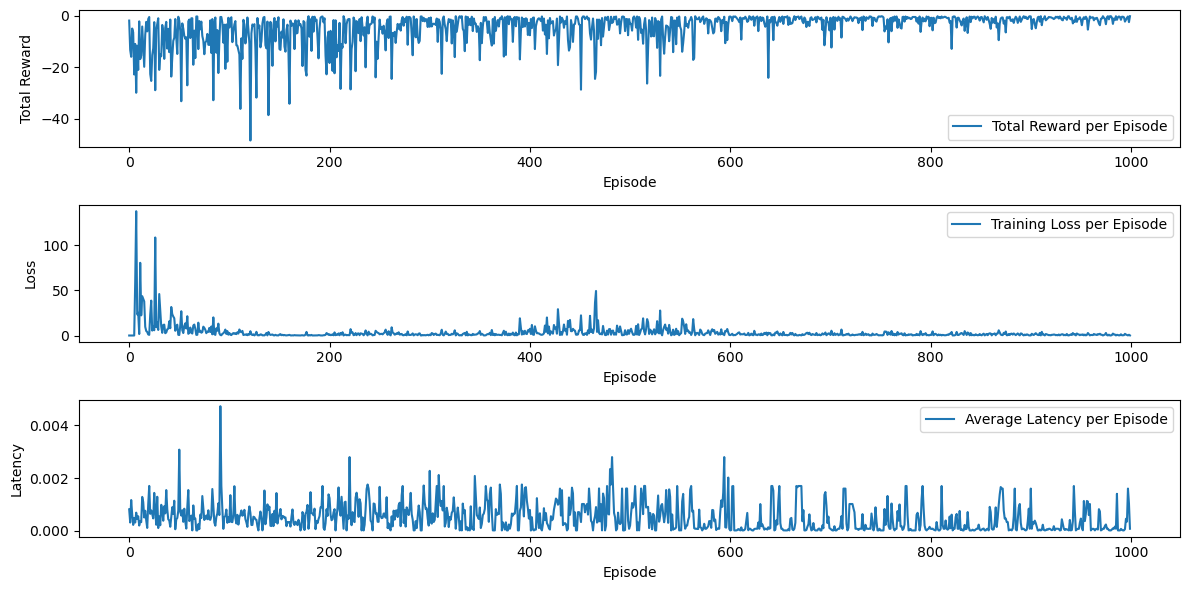

In [1]:
### start new Transferlerning edge device
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as pltimport random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the EdgeDevice class
class EdgeDevice:
    def __init__(self, id):
        self.id = id
        self.cpu_capacity = random.uniform(1.0, 3.0)  # GHz
        self.gpu_capacity = random.uniform(0.5, 2.0)  # GHz
        self.memory_capacity = random.uniform(4, 16)  # GB
        self.cpu_usage = 0
        self.gpu_usage = 0
        self.memory_usage = 0

    def can_handle_task(self, task):
        return (
            self.cpu_capacity - self.cpu_usage >= task.cpu_usage and
            self.gpu_capacity - self.gpu_usage >= task.gpu_usage and
            self.memory_capacity - self.memory_usage >= task.memory_usage
        )

    def assign_task(self, task):
        self.cpu_usage += task.cpu_usage
        self.gpu_usage += task.gpu_usage
        self.memory_usage += task.memory_usage
        return task.compute_cost()

    def reset(self):
        self.cpu_usage = 0
        self.gpu_usage = 0
        self.memory_usage = 0


# Define the Task class
class Task:
    def __init__(self, cpu_usage, gpu_usage, memory_usage):
        self.cpu_usage = cpu_usage
        self.gpu_usage = gpu_usage
        self.memory_usage = memory_usage

    def compute_cost(self):
        return self.cpu_usage + self.gpu_usage + self.memory_usage


# Define the DRL environment
class TaskSchedulingEnv:
    def __init__(self, n_devices=10, task_prob=0.5):
        self.devices = [EdgeDevice(i) for i in range(n_devices)]
        self.task_prob = task_prob
        self.reset()

    def reset(self):
        self.completed_tasks = 0
        self.total_task_cost = 0
        for device in self.devices:
            device.reset()

    def step(self, action, task):
        device = self.devices[action]
        reward = 0
        task_cost = 0

        if device.can_handle_task(task):
            task_cost = device.assign_task(task)
            reward = 1  # Task successfully completed
        else:
            reward = -1  # Task dropped due to overload

        self.completed_tasks += max(0, reward)  # Only count successful tasks
        self.total_task_cost += task_cost
        return reward, task_cost

    def generate_task(self):
        if random.random() < self.task_prob:
            cpu_usage = random.uniform(0.1, 0.5)
            gpu_usage = random.uniform(0.1, 0.5)
            memory_usage = random.uniform(0.5, 2.0)
            return Task(cpu_usage, gpu_usage, memory_usage)
        return None

    def get_state(self):
        state = []
        for device in self.devices:
            state.extend([
                device.cpu_capacity - device.cpu_usage,
                device.gpu_capacity - device.gpu_usage,
                device.memory_capacity - device.memory_usage
            ])
        return np.array(state)

    def get_completion_rate(self):
        return self.completed_tasks

    def get_average_task_cost(self):
        return self.total_task_cost / max(1, self.completed_tasks)


# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# Training loop
def train_drl(env, episodes, task_prob, batch_size=32, gamma=0.99, lr=0.001):
    state_dim = len(env.get_state())
    action_dim = len(env.devices)
    model = DQN(state_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    replay_buffer = []
    buffer_capacity = 10000

    rewards_history = []
    task_cost_history = []

    for episode in range(episodes):
        env.reset()
        state = env.get_state()
        total_reward = 0
        total_task_cost = 0

        for step in range(200):  # Limit steps per episode
            state_tensor = torch.tensor(state, dtype=torch.float32)
            q_values = model(state_tensor)
            action = q_values.argmax().item() if random.random() > 0.1 else random.randint(0, action_dim - 1)

            task = env.generate_task()
            if not task:
                continue

            reward, task_cost = env.step(action, task)
            total_reward += reward
            total_task_cost += task_cost

            next_state = env.get_state()
            replay_buffer.append((state, action, reward, next_state))
            if len(replay_buffer) > buffer_capacity:
                replay_buffer.pop(0)

            state = next_state

            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                for s, a, r, s_next in batch:
                    s_tensor = torch.tensor(s, dtype=torch.float32)
                    s_next_tensor = torch.tensor(s_next, dtype=torch.float32)
                    target = r + gamma * model(s_next_tensor).max().item()
                    prediction = model(s_tensor)[a]
                    loss = (target - prediction) ** 2
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

        rewards_history.append(total_reward)
        task_cost_history.append(total_task_cost / max(1, total_reward))

    return rewards_history, task_cost_history


# Main script
task_probs = [0.2, 0.4, 0.6, 0.8]
episodes = 500
all_rewards = []
all_task_costs = []

for task_prob in task_probs:
    env = TaskSchedulingEnv(task_prob=task_prob)
    rewards, task_costs = train_drl(env, episodes, task_prob)
    all_rewards.append(rewards)
    all_task_costs.append(task_costs)

# Plotting results
plt.figure(figsize=(12, 6))

# Completion rate plot
for i, task_prob in enumerate(task_probs):
    plt.plot(all_rewards[i], label=f'Task Prob = {task_prob}')
plt.title('Task Completion Rate')
plt.xlabel('Episodes')
plt.ylabel('Completion Rate')
plt.legend()
plt.show()

# Average task cost plot
plt.figure(figsize=(12, 6))
for i, task_prob in enumerate(task_probs):
    plt.plot(all_task_costs[i], label=f'Task Prob = {task_prob}')
plt.title('Average Task Cost')
plt.xlabel('Episodes')
plt.ylabel('Average Task Cost')
plt.legend()
plt.show()
from collections import deque
import random

# Load CSV file with edge device data
data = pd.read_csv('edge_device_data.csv')  # Contains CPU, GPU, Memory, Latency, Accuracy, Confidence
class DDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
# State and action sizes
state_size = data.shape[1]
action_size = len(data)

# Hyperparameters
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
memory_size = 10000
target_update = 10

# Initialize memory and models
memory = deque(maxlen=memory_size)
model = DDQN(state_size, action_size)
target_model = DDQN(state_size, action_size)
target_model.load_state_dict(model.state_dict())
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
def choose_action(state, epsilon):
    if random.random() <= epsilon:
        return random.randint(0, action_size - 1)
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_values = model(state)
        return torch.argmax(action_values).item()

def replay():
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze()
    next_actions = model(next_states).argmax(1)
    next_q_values = target_model(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
    targets = rewards + (1 - dones) * gamma * next_q_values

    loss = criterion(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()
num_episodes = 1000
losses = []
rewards = []
latencies = []

for episode in range(num_episodes):
    state = data.sample().values[0]  # Random initial state from data
    done = False
    total_reward = 0
    episode_loss = 0
    episode_latency = []

    while not done:
        action = choose_action(state, epsilon)
        next_state = data.iloc[action].values  # Next state based on selected device
        latency = next_state[3]  # Assume latency is at index 3
        episode_latency.append(latency)

        # Custom reward function based on latency and resource usage
        reward = -latency - next_state[0]  # Penalize high latency and CPU usage

        done = random.random() < 0.1  # Randomly end the episode
        total_reward += reward
        memory.append((state, action, reward, next_state, done))
        state = next_state

        loss = replay()
        if loss:
            episode_loss += loss

    losses.append(episode_loss)
    rewards.append(total_reward)
    latencies.append(np.mean(episode_latency))

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if episode % target_update == 0:
        target_model.load_state_dict(model.state_dict())

    print(f"Episode {episode+1}, Reward: {total_reward}, Loss: {episode_loss}, Epsilon: {epsilon:.4f}")

# Plot Training Results
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(rewards, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(losses, label='Training Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(latencies, label='Average Latency per Episode')
plt.xlabel('Episode')
plt.ylabel('Latency')
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
#### Actorf acrio with replaybuffer

import numpy as np

class EdgeDeviceEnv:
    def __init__(self, data_file):
        # Load state data: [CPU, GPU, Memory, Latency, Accuracy, Confidence]
        self.data = np.loadtxt(data_file, delimiter=',')
        self.num_devices = 5  # Assume 5 edge devices
        self.state_dim = self.data.shape[1]
        self.action_dim = self.num_devices  # One action per device
        self.current_index = 0

    def reset(self):
        self.current_index = 0
        return self.data[self.current_index]

    def step(self, action):
        # Get the current state
        state = self.data[self.current_index]
        # Reward: Maximize accuracy and confidence, minimize latency and resource usage
        accuracy = state[4]
        confidence = state[5]
        latency = state[3]
        cpu = state[0]
        gpu = state[1]
        memory = state[2]
        reward = accuracy + confidence - 0.5 * latency - 0.1 * (cpu + gpu + memory)

        # Move to the next state
        self.current_index += 1
        done = self.current_index >= len(self.data)
        next_state = self.data[self.current_index] if not done else None
        return next_state, reward, done, {"latency": latency, "confidence": confidence}
import torch
import torch.nn as nn

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)  # Output probabilities for devices
        )

    def forward(self, state):
        return self.fc(state)

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim + action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.fc(x)
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.float32),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def size(self):
        return len(self.buffer)
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 64
gamma = 0.99
actor_lr = 3e-4
critic_lr = 3e-4
replay_buffer_capacity = 10000
num_episodes = 500
max_steps = 100

# Initialize environment and models
env = EdgeDeviceEnv("edge_device_data.csv")
state_dim = env.state_dim
action_dim = env.action_dim

actor = Actor(state_dim, action_dim)
critic = Critic(state_dim, action_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)

replay_buffer = ReplayBuffer(replay_buffer_capacity)

# Tracking metrics
all_rewards = []
all_losses = []
latency_list = []
confidence_list = []

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    episode_loss = 0

    for step in range(max_steps):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_probs = actor(state_tensor)
        action = torch.multinomial(action_probs, 1).item()  # Select an action
        one_hot_action = torch.zeros(action_dim)
        one_hot_action[action] = 1.0

        next_state, reward, done, info = env.step(action)
        replay_buffer.add(state, one_hot_action.numpy(), reward, next_state or state, done)

        # Training
        if replay_buffer.size() >= batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

            # Critic loss
            q_values = critic(states, actions)
            with torch.no_grad():
                next_actions = actor(next_states)
                next_q_values = critic(next_states, next_actions)
                target_q_values = rewards + gamma * (1 - dones) * next_q_values
            critic_loss = nn.MSELoss()(q_values, target_q_values)

            # Actor loss
            new_actions = actor(states)
            actor_loss = -critic(states, new_actions).mean()

            # Optimize critic
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # Optimize actor
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            episode_loss += critic_loss.item() + actor_loss.item()

        state = next_state
        episode_reward += reward
        latency_list.append(info["latency"])
        confidence_list.append(info["confidence"])

        if done:
            break

    all_rewards.append(episode_reward)
    all_losses.append(episode_loss / step if step > 0 else 0)
    print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward:.2f}")

# Plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(all_rewards)
plt.title("Rewards")

plt.subplot(2, 2, 2)
plt.plot(all_losses)
plt.title("Losses")

plt.subplot(2, 2, 3)
plt.plot(latency_list)
plt.title("Latency")

plt.subplot(2, 2, 4)
plt.plot(confidence_list)
from sklearn.cluster import KMeans
import numpy as np
import torch

import numpy as np

class EdgeDeviceEnv:
    def __init__(self, data_file, latency_threshold=100, resource_threshold=1.0):
        # Load state data: [CPU, GPU, Memory, Latency, Accuracy, Confidence]
        self.data = np.loadtxt(data_file, delimiter=',')
        self.num_devices = 5  # Assume 5 edge devices
        self.state_dim = self.data.shape[1]
        self.action_dim = self.num_devices  # One action per device
        self.current_index = 0
        self.latency_threshold = latency_threshold
        self.resource_threshold = resource_threshold

    def reset(self):
        self.current_index = 0
        return self.data[self.current_index]

    def step(self, action):
        state = self.data[self.current_index]
        cpu, gpu, memory, latency, accuracy, confidence = state

        # Reward: Accuracy and confidence, penalized by resource utilization and latency
        reward = accuracy + confidence
        penalty = 0

        if latency > self.latency_threshold:
            penalty += 0.5 * (latency - self.latency_threshold)
        if cpu + gpu + memory > self.resource_threshold:
            penalty += 0.3 * (cpu + gpu + memory - self.resource_threshold)

        reward -= penalty

        self.current_index += 1
        done = self.current_index >= len(self.data)
        next_state = self.data[self.current_index] if not done else None
        return next_state, reward, done, {
            "latency": latency,
            "confidence": confidence,
            "penalty": penalty
        }


class DiversityReplayBuffer:
    def __init__(self, capacity, state_dim):
        self.capacity = capacity
        self.buffer = []
        self.state_dim = state_dim

    def add(self, state, action, reward, next_state, done):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)  # Remove the oldest experience
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        # Convert states to numpy array
        states = np.array([experience[0] for experience in self.buffer])
        # Perform clustering
        kmeans = KMeans(n_clusters=min(batch_size, len(states)), random_state=0)
        cluster_indices = kmeans.fit_predict(states)
        unique_indices = np.unique(cluster_indices, return_index=True)[1]
        diverse_sample_indices = [unique_indices[i] for i in range(len(unique_indices))]

        # Select diverse samples
        selected_experiences = [self.buffer[idx] for idx in diverse_sample_indices]
        # Pad if necessary
        while len(selected_experiences) < batch_size:
            selected_experiences.append(self.buffer[np.random.randint(0, len(self.buffer))])

        # Unpack experiences
        states, actions, rewards, next_states, dones = zip(*selected_experiences)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.float32),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def size(self):
        return len(self.buffer)
import torch
import torch.nn as nn

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)  # Output probabilities for devices
        )

    def forward(self, state):
        return self.fc(state)

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim + action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.fc(x)
from sklearn.cluster import KMeans
import numpy as np
import torch

class DiversityReplayBuffer:
    def __init__(self, capacity, state_dim):
        self.capacity = capacity
        self.buffer = []
        self.state_dim = state_dim

    def add(self, state, action, reward, next_state, done):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)  # Remove the oldest experience
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        # Convert states to numpy array
        states = np.array([experience[0] for experience in self.buffer])
        # Perform clustering
        kmeans = KMeans(n_clusters=min(batch_size, len(states)), random_state=0)
        cluster_indices = kmeans.fit_predict(states)
        unique_indices = np.unique(cluster_indices, return_index=True)[1]
        diverse_sample_indices = [unique_indices[i] for i in range(len(unique_indices))]

        # Select diverse samples
        selected_experiences = [self.buffer[idx] for idx in diverse_sample_indices]
        # Pad if necessary
        while len(selected_experiences) < batch_size:
            selected_experiences.append(self.buffer[np.random.randint(0, len(self.buffer))])

        # Unpack experiences
        states, actions, rewards, next_states, dones = zip(*selected_experiences)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.float32),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def size(self):
        return len(self.buffer)
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 64
gamma = 0.99
actor_lr = 3e-4
critic_lr = 3e-4
replay_buffer_capacity = 10000
num_episodes = 500
max_steps = 100

# Initialize environment and models
env = EdgeDeviceEnv("state_data.csv")
state_dim = env.state_dim
action_dim = env.action_dim

actor = Actor(state_dim, action_dim)
critic = Critic(state_dim, action_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)

replay_buffer = DiversityReplayBuffer(replay_buffer_capacity, state_dim)

# Tracking metrics
all_rewards = []
all_losses = []
latency_list = []
confidence_list = []
penalty_list = []

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    episode_loss = 0

    for step in range(max_steps):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_probs = actor(state_tensor)
        action = torch.multinomial(action_probs, 1).item()  # Select an action
        one_hot_action = torch.zeros(action_dim)
        one_hot_action[action] = 1.0

        next_state, reward, done, info = env.step(action)
        replay_buffer.add(state, one_hot_action.numpy(), reward, next_state or state, done)

        # Training
        if replay_buffer.size() >= batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

            # Critic loss
            q_values = critic(states, actions)
            with torch.no_grad():
                next_actions = actor(next_states)
                next_q_values = critic(next_states, next_actions)
                target_q_values = rewards + gamma * (1 - dones) * next_q_values
            critic_loss = nn.MSELoss()(q_values, target_q_values)

            # Actor loss
            new_actions = actor(states)
            actor_loss = -critic(states, new_actions).mean()

            # Optimize critic
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # Optimize actor
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            episode_loss += critic_loss.item() + actor_loss.item()

        state = next_state
        episode_reward += reward
        latency_list.append(info["latency"])
        confidence_list.append(info["confidence"])
        penalty_list.append(info["penalty"])

        if done:
            break

    all_rewards.append(episode_reward)
    all_losses.append(episode_loss / step if step > 0 else 0)
    print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward:.2f}")

# Plot results
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(all_rewards)
plt.title("Rewards")

plt.subplot(2, 2, 2)
plt.plot(all_losses)
plt.title("Losses")

plt.subplot(2, 2, 3)
plt.plot(latency_list)
plt.title("Latency")

plt.subplot(2, 2, 4)
plt.plot(confidence_list)
plt.title("Confidence")

plt.tight_layout()
plt.show()
plt.title("Confidence")

plt.tight_layout()
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [5]:
####  diversity replay buffer

from sklearn.cluster import KMeans
import numpy as np
import torch

import numpy as np

class EdgeDeviceEnv:
    def __init__(self, data_file, latency_threshold=100, resource_threshold=1.0):
        # Load state data: [CPU, GPU, Memory, Latency, Accuracy, Confidence]
        self.data = np.loadtxt(data_file, delimiter=',')
        self.num_devices = 5  # Assume 5 edge devices
        self.state_dim = self.data.shape[1]
        self.action_dim = self.num_devices  # One action per device
        self.current_index = 0
        self.latency_threshold = latency_threshold
        self.resource_threshold = resource_threshold

    def reset(self):
        self.current_index = 0
        return self.data[self.current_index]

    def step(self, action):
        state = self.data[self.current_index]
        cpu, gpu, memory, latency, accuracy, confidence = state

        # Reward: Accuracy and confidence, penalized by resource utilization and latency
        reward = accuracy + confidence
        penalty = 0

        if latency > self.latency_threshold:
            penalty += 0.5 * (latency - self.latency_threshold)
        if cpu + gpu + memory > self.resource_threshold:
            penalty += 0.3 * (cpu + gpu + memory - self.resource_threshold)

        reward -= penalty

        self.current_index += 1
        done = self.current_index >= len(self.data)
        next_state = self.data[self.current_index] if not done else None
        return next_state, reward, done, {
            "latency": latency,
            "confidence": confidence,
            "penalty": penalty
        }


class DiversityReplayBuffer:
    def __init__(self, capacity, state_dim):
        self.capacity = capacity
        self.buffer = []
        self.state_dim = state_dim

    def add(self, state, action, reward, next_state, done):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)  # Remove the oldest experience
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        # Convert states to numpy array
        states = np.array([experience[0] for experience in self.buffer])
        # Perform clustering
        kmeans = KMeans(n_clusters=min(batch_size, len(states)), random_state=0)
        cluster_indices = kmeans.fit_predict(states)
        unique_indices = np.unique(cluster_indices, return_index=True)[1]
        diverse_sample_indices = [unique_indices[i] for i in range(len(unique_indices))]

        # Select diverse samples
        selected_experiences = [self.buffer[idx] for idx in diverse_sample_indices]
        # Pad if necessary
        while len(selected_experiences) < batch_size:
            selected_experiences.append(self.buffer[np.random.randint(0, len(self.buffer))])

        # Unpack experiences
        states, actions, rewards, next_states, dones = zip(*selected_experiences)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.float32),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def size(self):
        return len(self.buffer)
import torch
import torch.nn as nn

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)  # Output probabilities for devices
        )

    def forward(self, state):
        return self.fc(state)

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim + action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.fc(x)
from sklearn.cluster import KMeans
import numpy as np
import torch

class DiversityReplayBuffer:
    def __init__(self, capacity, state_dim):
        self.capacity = capacity
        self.buffer = []import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the EdgeDevice class
class EdgeDevice:
    def __init__(self, id):
        self.id = id
        self.cpu_capacity = random.uniform(1.0, 3.0)  # GHz
        self.gpu_capacity = random.uniform(0.5, 2.0)  # GHz
        self.memory_capacity = random.uniform(4, 16)  # GB
        self.cpu_usage = 0
        self.gpu_usage = 0
        self.memory_usage = 0

    def can_handle_task(self, task):
        return (
            self.cpu_capacity - self.cpu_usage >= task.cpu_usage and
            self.gpu_capacity - self.gpu_usage >= task.gpu_usage and
            self.memory_capacity - self.memory_usage >= task.memory_usage
        )

    def assign_task(self, task):
        self.cpu_usage += task.cpu_usage
        self.gpu_usage += task.gpu_usage
        self.memory_usage += task.memory_usage
        return task.compute_cost()

    def reset(self):
        self.cpu_usage = 0
        self.gpu_usage = 0
        self.memory_usage = 0


# Define the Task class
class Task:
    def __init__(self, cpu_usage, gpu_usage, memory_usage):
        self.cpu_usage = cpu_usage
        self.gpu_usage = gpu_usage
        self.memory_usage = memory_usage

    def compute_cost(self):
        return self.cpu_usage + self.gpu_usage + self.memory_usage


# Define the DRL environment
class TaskSchedulingEnv:
    def __init__(self, n_devices=10, task_prob=0.5):
        self.devices = [EdgeDevice(i) for i in range(n_devices)]
        self.task_prob = task_prob
        self.reset()

    def reset(self):
        self.completed_tasks = 0
        self.total_task_cost = 0
        for device in self.devices:
            device.reset()

    def step(self, action, task):
        device = self.devices[action]
        reward = 0
        task_cost = 0

        if device.can_handle_task(task):
            task_cost = device.assign_task(task)
            reward = 1  # Task successfully completed
        else:
            reward = -1  # Task dropped due to overload

        self.completed_tasks += max(0, reward)  # Only count successful tasks
        self.total_task_cost += task_cost
        return reward, task_cost

    def generate_task(self):
        if random.random() < self.task_prob:
            cpu_usage = random.uniform(0.1, 0.5)
            gpu_usage = random.uniform(0.1, 0.5)
            memory_usage = random.uniform(0.5, 2.0)
            return Task(cpu_usage, gpu_usage, memory_usage)
        return None

    def get_state(self):
        state = []
        for device in self.devices:
            state.extend([
                device.cpu_capacity - device.cpu_usage,
                device.gpu_capacity - device.gpu_usage,
                device.memory_capacity - device.memory_usage
            ])
        return np.array(state)

    def get_completion_rate(self):
        return self.completed_tasks

    def get_average_task_cost(self):
        return self.total_task_cost / max(1, self.completed_tasks)


# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# Training loop
def train_drl(env, episodes, task_prob, batch_size=32, gamma=0.99, lr=0.001):
    state_dim = len(env.get_state())
    action_dim = len(env.devices)
    model = DQN(state_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    replay_buffer = []
    buffer_capacity = 10000

    rewards_history = []
    task_cost_history = []

    for episode in range(episodes):
        env.reset()
        state = env.get_state()
        total_reward = 0
        total_task_cost = 0

        for step in range(200):  # Limit steps per episode
            state_tensor = torch.tensor(state, dtype=torch.float32)
            q_values = model(state_tensor)
            action = q_values.argmax().item() if random.random() > 0.1 else random.randint(0, action_dim - 1)

            task = env.generate_task()
            if not task:
                continue

            reward, task_cost = env.step(action, task)
            total_reward += reward
            total_task_cost += task_cost

            next_state = env.get_state()
            replay_buffer.append((state, action, reward, next_state))
            if len(replay_buffer) > buffer_capacity:
                replay_buffer.pop(0)

            state = next_state

            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                for s, a, r, s_next in batch:
                    s_tensor = torch.tensor(s, dtype=torch.float32)
                    s_next_tensor = torch.tensor(s_next, dtype=torch.float32)
                    target = r + gamma * model(s_next_tensor).max().item()
                    prediction = model(s_tensor)[a]
                    loss = (target - prediction) ** 2
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

        rewards_history.append(total_reward)
        task_cost_history.append(total_task_cost / max(1, total_reward))

    return rewards_history, task_cost_history


# Main script
task_probs = [0.2, 0.4, 0.6, 0.8]
episodes = 500
all_rewards = []
all_task_costs = []

for task_prob in task_probs:
    env = TaskSchedulingEnv(task_prob=task_prob)
    rewards, task_costs = train_drl(env, episodes, task_prob)
    all_rewards.append(rewards)
    all_task_costs.append(task_costs)

# Plotting results
plt.figure(figsize=(12, 6))

# Completion rate plot
for i, task_prob in enumerate(task_probs):
    plt.plot(all_rewards[i], label=f'Task Prob = {task_prob}')
plt.title('Task Completion Rate')
plt.xlabel('Episodes')
plt.ylabel('Completion Rate')
plt.legend()
plt.show()

# Average task cost plot
plt.figure(figsize=(12, 6))
for i, task_prob in enumerate(task_probs):
    plt.plot(all_task_costs[i], label=f'Task Prob = {task_prob}')
plt.title('Average Task Cost')
plt.xlabel('Episodes')
plt.ylabel('Average Task Cost')
plt.legend()
plt.show()
        self.state_dim = state_dim

    def add(self, state, action, reward, next_state, done):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)  # Remove the oldest experience
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        # Convert states to numpy array
        states = np.array([experience[0] for experience in self.buffer])
        # Perform clustering
        kmeans = KMeans(n_clusters=min(batch_size, len(states)), random_state=0)
        cluster_indices = kmeans.fit_predict(states)
        unique_indices = np.unique(cluster_indices, return_index=True)[1]
        diverse_sample_indices = [unique_indices[i] for i in range(len(unique_indices))]

        # Select diverse samples
        selected_experiences = [self.buffer[idx] for idx in diverse_sample_indices]
        # Pad if necessary
        while len(selected_experiences) < batch_size:
            selected_experiences.append(self.buffer[np.random.randint(0, len(self.buffer))])

        # Unpack experiences
        states, actions, rewards, next_states, dones = zip(*selected_experiences)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.float32),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def size(self):
        return len(self.buffer)
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 64
gamma = 0.99
actor_lr = 3e-4
critic_lr = 3e-4
replay_buffer_capacity = 10000
num_episodes = 500
max_steps = 100

# Initialize environment and models
env = EdgeDeviceEnv("edge_device_data.csv")
state_dim = env.state_dim
action_dim = env.action_dim

actor = Actor(state_dim, action_dim)
critic = Critic(state_dim, action_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)

replay_buffer = DiversityReplayBuffer(replay_buffer_capacity, state_dim)

# Tracking metrics
all_rewards = []
all_losses = []
latency_list = []
confidence_list = []
penalty_list = []

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    episode_loss = 0

    for step in range(max_steps):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_probs = actor(state_tensor)
        action = torch.multinomial(action_probs, 1).item()  # Select an action
        one_hot_action = torch.zeros(action_dim)
        one_hot_action[action] = 1.0

        next_state, reward, done, info = env.step(action)
        replay_buffer.add(state, one_hot_action.numpy(), reward, next_state or state, done)

        # Training
        if replay_buffer.size() >= batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

            # Critic loss
            q_values = critic(states, actions)
            with torch.no_grad():
                next_actions = actor(next_states)
                next_q_values = critic(next_states, next_actions)
                target_q_values = rewards + gamma * (1 - dones) * next_q_values
            critic_loss = nn.MSELoss()(q_values, target_q_values)

            # Actor loss
            new_actions = actor(states)
            actor_loss = -critic(states, new_actions).mean()

            # Optimize critic
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # Optimize actor
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            episode_loss += critic_loss.item() + actor_loss.item()

        state = next_state
        episode_reward += reward
        latency_list.append(info["latency"])
        confidence_list.append(info["confidence"])
        penalty_list.append(info["penalty"])

        if done:
            break

    all_rewards.append(episode_reward)
    all_losses.append(episode_loss / step if step > 0 else 0)
    print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward:.2f}")

# Plot results
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(all_rewards)
plt.title("Rewards")

plt.subplot(2, 2, 2)
plt.plot(all_losses)
plt.title("Losses")

plt.subplot(2, 2, 3)
plt.plot(latency_list)
plt.title("Latency")

plt.subplot(2, 2, 4)
plt.plot(confidence_list)
plt.title("Confidence")

plt.tight_layout()
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

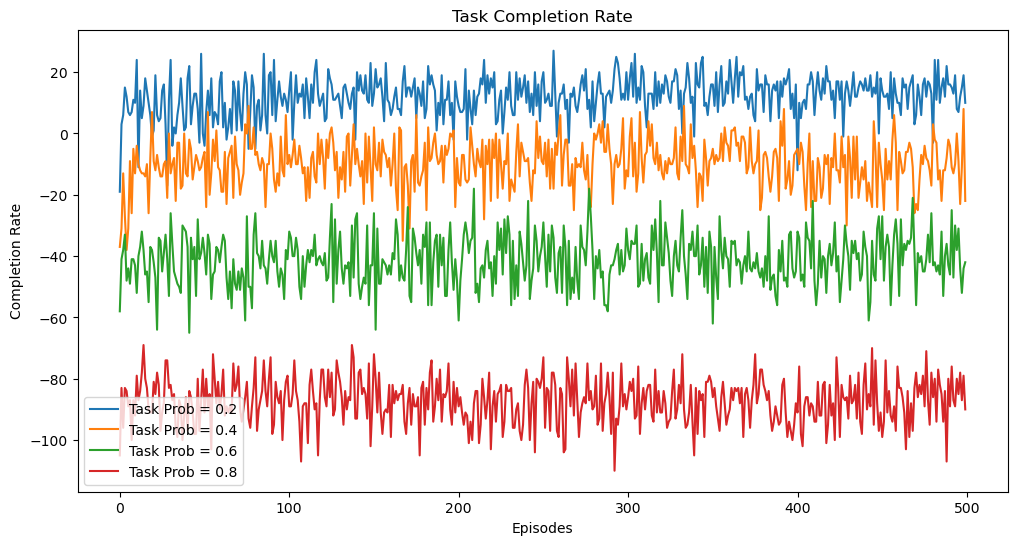

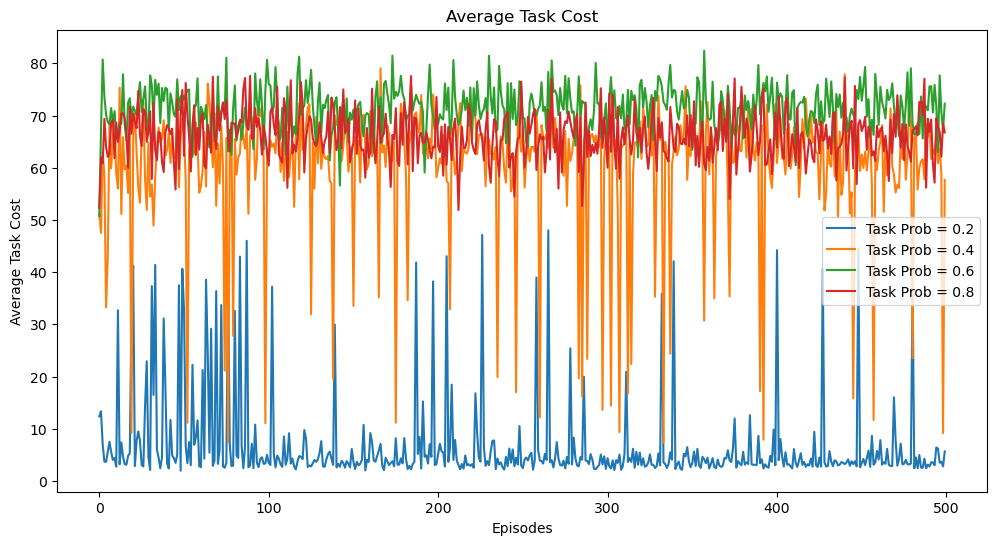

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the EdgeDevice class
class EdgeDevice:
    def __init__(self, id):
        self.id = id
        self.cpu_capacity = random.uniform(1.0, 3.0)  # GHz
        self.gpu_capacity = random.uniform(0.5, 2.0)  # GHz
        self.memory_capacity = random.uniform(4, 16)  # GB
        self.cpu_usage = 0
        self.gpu_usage = 0
        self.memory_usage = 0

    def can_handle_task(self, task):
        return (
            self.cpu_capacity - self.cpu_usage >= task.cpu_usage and
            self.gpu_capacity - self.gpu_usage >= task.gpu_usage and
            self.memory_capacity - self.memory_usage >= task.memory_usage
        )

    def assign_task(self, task):
        self.cpu_usage += task.cpu_usage
        self.gpu_usage += task.gpu_usage
        self.memory_usage += task.memory_usage
        return task.compute_cost()

    def reset(self):
        self.cpu_usage = 0
        self.gpu_usage = 0
        self.memory_usage = 0


# Define the Task class
class Task:
    def __init__(self, cpu_usage, gpu_usage, memory_usage):
        self.cpu_usage = cpu_usage
        self.gpu_usage = gpu_usage
        self.memory_usage = memory_usage

    def compute_cost(self):
        return self.cpu_usage + self.gpu_usage + self.memory_usage


# Define the DRL environment
class TaskSchedulingEnv:
    def __init__(self, n_devices=10, task_prob=0.5):
        self.devices = [EdgeDevice(i) for i in range(n_devices)]
        self.task_prob = task_prob
        self.reset()

    def reset(self):
        self.completed_tasks = 0
        self.total_task_cost = 0
        for device in self.devices:
            device.reset()

    def step(self, action, task):
        device = self.devices[action]
        reward = 0
        task_cost = 0

        if device.can_handle_task(task):
            task_cost = device.assign_task(task)
            reward = 1  # Task successfully completed
        else:
            reward = -1  # Task dropped due to overload

        self.completed_tasks += max(0, reward)  # Only count successful tasks
        self.total_task_cost += task_cost
        return reward, task_cost

    def generate_task(self):
        if random.random() < self.task_prob:
            cpu_usage = random.uniform(0.1, 0.5)
            gpu_usage = random.uniform(0.1, 0.5)
            memory_usage = random.uniform(0.5, 2.0)
            return Task(cpu_usage, gpu_usage, memory_usage)
        return None

    def get_state(self):
        state = []
        for device in self.devices:
            state.extend([
                device.cpu_capacity - device.cpu_usage,
                device.gpu_capacity - device.gpu_usage,
                device.memory_capacity - device.memory_usage
            ])
        return np.array(state)

    def get_completion_rate(self):
        return self.completed_tasks

    def get_average_task_cost(self):
        return self.total_task_cost / max(1, self.completed_tasks)


# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# Training loop
def train_drl(env, episodes, task_prob, batch_size=32, gamma=0.99, lr=0.001):
    state_dim = len(env.get_state())
    action_dim = len(env.devices)
    model = DQN(state_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    replay_buffer = []
    buffer_capacity = 10000

    rewards_history = []
    task_cost_history = []

    for episode in range(episodes):
        env.reset()
        state = env.get_state()
        total_reward = 0
        total_task_cost = 0

        for step in range(200):  # Limit steps per episode
            state_tensor = torch.tensor(state, dtype=torch.float32)
            q_values = model(state_tensor)
            action = q_values.argmax().item() if random.random() > 0.1 else random.randint(0, action_dim - 1)

            task = env.generate_task()
            if not task:
                continue

            reward, task_cost = env.step(action, task)
            total_reward += reward
            total_task_cost += task_cost

            next_state = env.get_state()
            replay_buffer.append((state, action, reward, next_state))
            if len(replay_buffer) > buffer_capacity:
                replay_buffer.pop(0)
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the EdgeDevice class
class EdgeDevice:
    def __init__(self, id):
        self.id = id
        self.cpu_capacity = random.uniform(1.0, 3.0)  # GHz
        self.gpu_capacity = random.uniform(0.5, 2.0)  # GHz
        self.memory_capacity = random.uniform(4, 16)  # GBimport pandas as pd
import random

# Generate a sample CSV file
data = {
    "CPU": [random.uniform(0.5, 2.5) for _ in range(10)],
    "GPU": [random.uniform(0.5, 1.5) for _ in range(10)],
    "InferenceLatency": [random.uniform(10, 50) for _ in range(10)],
    "CurrentLoad": [random.uniform(0.1, 1.0) for _ in range(10)],
    "ResourceCost": [random.uniform(0.1, 1.0) for _ in range(10)],
}

df = pd.DataFrame(data)
df.to_csv("edge_devices.csv", index=False)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingQNetwork, self).__init__()
        self.feature_layer = nn.Linear(state_size, 128)
        self.value_stream = nn.Linear(128, 1)
        self.advantage_stream = nn.Linear(128, action_size)

    def forward(self, x):
        features = torch.relu(self.feature_layer(x))
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values


class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.memory = []
        self.priorities = []
        self.alpha = alpha

    def add(self, experience, priority=1.0):
        self.memory.append(experience)
        self.priorities.append(priority ** self.alpha)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)
            self.priorities.pop(0)

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities)
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)
        samples = [self.memory[i] for i in indices]
        weights = (len(self.memory) * probabilities[indices]) ** -beta
        weights /= weights.max()
        return samples, indices, torch.FloatTensor(weights)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority ** self.alpha


class DDQNAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99, tau=0.001, epsilon_decay=0.995, min_epsilon=0.01):
        self.state_size = state_size
        self.action_size = action_size

        # Dueling Q-Networks
        self.q_net = DuelingQNetwork(state_size, action_size)
        self.target_net = DuelingQNetwork(state_size, action_size)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.memory = PrioritizedReplayMemory(capacity=10000)

        # Hyperparameters
        self.gamma = gamma
        self.tau = tau
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

    def act(self, state, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.q_net(state_tensor)).item()

    def train(self, batch_size=64, beta=0.4):
        if len(self.memory.memory) < batch_size:
            return

        # Sample from prioritized replay memory
        samples, indices, weights = self.memory.sample(batch_size, beta)
        states, actions, rewards, next_states, dones = zip(*samples)

        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Q-values and targets
        q_values = self.q_net(states).gather(1, actions)
        next_actions = self.q_net(next_states).argmax(1, keepdim=True)
        next_q_values = self.target_net(next_states).gather(1, next_actions)
        targets = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss with importance-sampling weights
        td_errors = targets - q_values
        loss = (weights.unsqueeze(1) * td_errors ** 2).mean()

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update priorities in memory
        priorities = abs(td_errors.detach().squeeze().numpy()) + 1e-6
        self.memory.update_priorities(indices, priorities)

        # Update target network slowly
        for target_param, local_param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

        return loss.item()

    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
class EdgeComputingEnvironment:
    def __init__(self, csv_file, num_devices):
        self.data = pd.read_csv(csv_file).to_dict('records')
        self.num_devices = num_devices
        self.state = self.reset()

    def reset(self):
        for device in self.data:
            device['CurrentLoad'] = random.uniform(0.1, 1.0)
        return self._get_state()

    def _get_state(self):
        state = []
        for device in self.data:
            state.extend([device['CPU'], device['GPU'], device['InferenceLatency'], device['CurrentLoad'], device['ResourceCost']])
        return state

    def step(self, action, task_workload):
        device = self.data[action]
        reward = 0
        task_completed = 0
        task_dropped = 0

        if device['CurrentLoad'] + task_workload <= 1.0:
            device['CurrentLoad'] += task_workload
            reward = -device['ResourceCost'] * task_workload
            task_completed = 1
        else:
            reward = -1  # Penalty for dropping the task
            task_dropped = 1

        return self._get_state(), reward, task_completed, task_dropped

    def calculate_metrics(self):
        completion_rate = sum(1 - device['CurrentLoad'] for device in self.data) / len(self.data)
        avg_cost = sum(device['ResourceCost'] * device['CurrentLoad'] for device in self.data) / len(self.data)
        return completion_rate, avg_cost
env = EdgeComputingEnvironment("edge_devices.csv", num_devices=10)
agent = DDQNAgent(state_size=50, action_size=10)

task_probs = [0.1, 0.2, 0.3, 0.4, 0.5]
results = []

for prob in task_probs:
    task_generation_probability = prob
    total_rewards = []
    total_losses = []
    tasks_completed = 0
    tasks_dropped = 0

    for episode in range(100):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            task_workload = np.random.uniform(0.1, task_generation_probability)
            next_state, reward, completed, dropped = env.step(action, task_workload)

            agent.memory.add((state, action, reward, next_state, False), priority=abs(reward))
            loss = agent.train(batch_size=64)

            state = next_state
            total_reward += reward
            tasks_completed += completed
            tasks_dropped += dropped

        agent.update_epsilon()
        total_rewards.append(total_reward)
        total_losses.append(loss)

    completion_rate, avg_cost = env.calculate_metrics()
    results.append((prob, completion_rate, avg_cost, tasks_completed, tasks_dropped))

# Plot Results
import matplotlib.pyplot as plt

# Unpack results
task_probs = [x[0] for x in results]
completion_rates = [x[1] for x in results]
avg_costs = [x[2] for x in results]
tasks_dropped = [x[4] for x in results]

# Plot Completion Rate
plt.figure()
plt.plot(task_probs, completion_rates, label="Completion Rate", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Completion Rate")
plt.title("Completion Rate vs Task Generation Probability")
plt.legend()
plt.show()

# Plot Average Task Cost
plt.figure()
plt.plot(task_probs, avg_costs, label="Average Task Cost", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Average Task Cost")
plt.title("Average Task Cost vs Task Generation Probability")
plt.legend()
plt.show()

# Plot Tasks Dropped
plt.figure()
plt.plot(task_probs, tasks_dropped, label="Tasks Dropped", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Tasks Dropped")
plt.title("Tasks Dropped vs Task Generation Probability")
plt.legend()
plt.show()

        self.cpu_usage = 0
        self.gpu_usage = 0
        self.memory_usage = 0

    def can_handle_task(self, task):
        return (
            self.cpu_capacity - self.cpu_usage >= task.cpu_usage and
            self.gpu_capacity - self.gpu_usage >= task.gpu_usage and
            self.memory_capacity - self.memory_usage >= task.memory_usage
        )

    def assign_task(self, task):
        self.cpu_usage += task.cpu_usage
        self.gpu_usage += task.gpu_usage
        self.memory_usage += task.memory_usage
        return task.compute_cost()

    def reset(self):
        self.cpu_usage = 0
        self.gpu_usage = 0
        self.memory_usage = 0


# Define the Task class
class Task:
    def __init__(self, cpu_usage, gpu_usage, memory_usage):
        self.cpu_usage = cpu_usage
        self.gpu_usage = gpu_usage
        self.memory_usage = memory_usage

    def compute_cost(self):
        return self.cpu_usage + self.gpu_usage + self.memory_usage


# Define the DRL environment
class TaskSchedulingEnv:
    def __init__(self, n_devices=10, task_prob=0.5):
        self.devices = [EdgeDevice(i) for i in range(n_devices)]
        self.task_prob = task_prob
        self.reset()

    def reset(self):
        self.completed_tasks = 0
        self.total_task_cost = 0
        for device in self.devices:
            device.reset()

    def step(self, action, task):
        device = self.devices[action]
        reward = 0
        task_cost = 0

        if device.can_handle_task(task):
            task_cost = device.assign_task(task)
            reward = 1  # Task successfully completed
        else:
            reward = -1  # Task dropped due to overload

        self.completed_tasks += max(0, reward)  # Only count successful tasks
        self.total_task_cost += task_cost
        return reward, task_cost

    def generate_task(self):
        if random.random() < self.task_prob:
            cpu_usage = random.uniform(0.1, 0.5)
            gpu_usage = random.uniform(0.1, 0.5)
            memory_usage = random.uniform(0.5, 2.0)
            return Task(cpu_usage, gpu_usage, memory_usage)
        return None

    def get_state(self):
        state = []
        for device in self.devices:
            state.extend([
                device.cpu_capacity - device.cpu_usage,
                device.gpu_capacity - device.gpu_usage,
                device.memory_capacity - device.memory_usage
            ])
        return np.array(state)

    def get_completion_rate(self):
        return self.completed_tasks

    def get_average_task_cost(self):
        return self.total_task_cost / max(1, self.completed_tasks)


# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# Training loop
def train_drl(env, episodes, task_prob, batch_size=32, gamma=0.99, lr=0.001):
    state_dim = len(env.get_state())
    action_dim = len(env.devices)
    model = DQN(state_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    replay_buffer = []
    buffer_capacity = 10000

    rewards_history = []
    task_cost_history = []

    for episode in range(episodes):
        env.reset()
        state = env.get_state()
        total_reward = 0
        total_task_cost = 0

        for step in range(200):  # Limit steps per episode
            state_tensor = torch.tensor(state, dtype=torch.float32)
            q_values = model(state_tensor)
            action = q_values.argmax().item() if random.random() > 0.1 else random.randint(0, action_dim - 1)

            task = env.generate_task()
            if not task:
                continue

            reward, task_cost = env.step(action, task)
            total_reward += reward
            total_task_cost += task_cost

            next_state = env.get_state()
            replay_buffer.append((state, action, reward, next_state))
            if len(replay_buffer) > buffer_capacity:
                replay_buffer.pop(0)

            state = next_state

            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                for s, a, r, s_next in batch:
                    s_tensor = torch.tensor(s, dtype=torch.float32)
                    s_next_tensor = torch.tensor(s_next, dtype=torch.float32)
                    target = r + gamma * model(s_next_tensor).max().item()
                    prediction = model(s_tensor)[a]
                    loss = (target - prediction) ** 2
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

        rewards_history.append(total_reward)
        task_cost_history.append(total_task_cost / max(1, total_reward))

    return rewards_history, task_cost_history


# Main script
task_probs = [0.2, 0.4, 0.6, 0.8]
episodes = 500
all_rewards = []
all_task_costs = []

for task_prob in task_probs:
    env = TaskSchedulingEnv(task_prob=task_prob)
    rewards, task_costs = train_drl(env, episodes, task_prob)
    all_rewards.append(rewards)
    all_task_costs.append(task_costs)

# Plotting results
plt.figure(figsize=(12, 6))

# Completion rate plot
for i, task_prob in enumerate(task_probs):
    plt.plot(all_rewards[i], label=f'Task Prob = {task_prob}')
plt.title('Task Completion Rate')
plt.xlabel('Episodes')
plt.ylabel('Completion Rate')
plt.legend()
plt.show()

# Average task cost plot
plt.figure(figsize=(12, 6))
for i, task_prob in enumerate(task_probs):
    plt.plot(all_task_costs[i], label=f'Task Prob = {task_prob}')
plt.title('Average Task Cost')
plt.xlabel('Episodes')
plt.ylabel('Average Task Cost')
plt.legend()
plt.show()
            state = next_state

            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                for s, a, r, s_next in batch:
                    s_tensor = torch.tensor(s, dtype=torch.float32)
                    s_next_tensor = torch.tensor(s_next, dtype=torch.float32)
                    target = r + gamma * model(s_next_tensor).max().item()
                    prediction = model(s_tensor)[a]
                    loss = (target - prediction) ** 2
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

        rewards_history.append(total_reward)
        task_cost_history.append(total_task_cost / max(1, total_reward))

    return rewards_history, task_cost_history


# Main script
task_probs = [0.2, 0.4, 0.6, 0.8]
episodes = 500
all_rewards = []
all_task_costs = []

for task_prob in task_probs:
    env = TaskSchedulingEnv(task_prob=task_prob)
    rewards, task_costs = train_drl(env, episodes, task_prob)
    all_rewards.append(rewards)
    all_task_costs.append(task_costs)

# Plotting results
plt.figure(figsize=(12, 6))

# Completion rate plot
for i, task_prob in enumerate(task_probs):
    plt.plot(all_rewards[i], label=f'Task Prob = {task_prob}')
plt.title('Task Completion Rate')
plt.xlabel('Episodes')
plt.ylabel('Completion Rate')
plt.legend()
plt.show()

# Average task cost plot
plt.figure(figsize=(12, 6))
for i, task_prob in enumerate(task_probs):
    plt.plot(all_task_costs[i], label=f'Task Prob = {task_prob}')
plt.title('Average Task Cost')
plt.xlabel('Episodes')
plt.ylabel('Average Task Cost')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import random

# Generate a sample CSV file
data = {
    "CPU": [random.uniform(0.5, 2.5) for _ in range(10)],
    "GPU": [random.uniform(0.5, 1.5) for _ in range(10)],
    "InferenceLatency": [random.uniform(10, 50) for _ in range(10)],
    "CurrentLoad": [random.uniform(0.1, 1.0) for _ in range(10)],
    "ResourceCost": [random.uniform(0.1, 1.0) for _ in range(10)],
}

df = pd.DataFrame(data)
df.to_csv("edge_devices.csv", index=False)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingQNetwork, self).__init__()
        self.feature_layer = nn.Linear(state_size, 128)
        self.value_stream = nn.Linear(128, 1)
        self.advantage_stream = nn.Linear(128, action_size)

    def forward(self, x):
        features = torch.relu(self.feature_layer(x))
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values


class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.memory = []
        self.priorities = []
        self.alpha = alpha

    def add(self, experience, priority=1.0):
        self.memory.append(experience)
        self.priorities.append(priority ** self.alpha)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)
            self.priorities.pop(0)

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities)
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)
        samples = [self.memory[i] for i in indices]
        weights = (len(self.memory) * probabilities[indices]) ** -beta
        weights /= weights.max()
        return samples, indices, torch.FloatTensor(weights)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority ** self.alpha


class DDQNAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99, tau=0.001, epsilon_decay=0.995, min_epsilon=0.01):
        self.state_size = state_size
        self.action_size = action_size

        # Dueling Q-Networks
        self.q_net = DuelingQNetwork(state_size, action_size)
        self.target_net = DuelingQNetwork(state_size, action_size)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.memory = PrioritizedReplayMemory(capacity=10000)

        # Hyperparameters
        self.gamma = gamma
        self.tau = tau
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

    def act(self, state, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.q_net(state_tensor)).item()

    def train(self, batch_size=64, beta=0.4):
        if len(self.memory.memory) < batch_size:
            return

        # Sample from prioritized replay memory
        samples, indices, weights = self.memory.sample(batch_size, beta)
        states, actions, rewards, next_states, dones = zip(*samples)

        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Q-values and targets
        q_values = self.q_net(states).gather(1, actions)
        next_actions = self.q_net(next_states).argmax(1, keepdim=True)
        next_q_values = self.target_net(next_states).gather(1, next_actions)
        targets = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss with importance-sampling weights
        td_errors = targets - q_values
        loss = (weights.unsqueeze(1) * td_errors ** 2).mean()

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update priorities in memory
        priorities = abs(td_errors.detach().squeeze().numpy()) + 1e-6
        self.memory.update_priorities(indices, priorities)

        # Update target network slowly
        for target_param, local_param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

        return loss.item()

    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
class EdgeComputingEnvironment:
    def __init__(self, csv_file, num_devices):
        self.data = pd.read_csv(csv_file).to_dict('records')
        self.num_devices = num_devices
        self.state = self.reset()

    def reset(self):
        for device in self.data:
            device['CurrentLoad'] = random.uniform(0.1, 1.0)
        return self._get_state()

    def _get_state(self):
        state = []
        for device in self.data:
            state.extend([device['CPU'], device['GPU'], device['InferenceLatency'], device['CurrentLoad'], device['ResourceCost']])
        return state

    def step(self, action, task_workload):
        device = self.data[action]
        reward = 0
        task_completed = 0
        task_dropped = 0

        if device['CurrentLoad'] + task_workload <= 1.0:
            device['CurrentLoad'] += task_workload
            reward = -device['ResourceCost'] * task_workload
            task_completed = 1
        else:
            reward = -1  # Penalty for dropping the task
            task_dropped = 1

        return self._get_state(), reward, task_completed, task_dropped

    def calculate_metrics(self):
        completion_rate = sum(1 - device['CurrentLoad'] for device in self.data) / len(self.data)
        avg_cost = sum(device['ResourceCost'] * device['CurrentLoad'] for device in self.data) / len(self.data)
        return completion_rate, avg_cost
env = EdgeComputingEnvironment("edge_devices.csv", num_devices=10)
agent = DDQNAgent(state_size=50, action_size=10)

task_probs = [0.1, 0.2, 0.3, 0.4, 0.5]
results = []

for prob in task_probs:
    task_generation_probability = prob
    total_rewards = []
    total_losses = []
    tasks_completed = 0
    tasks_dropped = 0

    for episode in range(100):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            task_workload = np.random.uniform(0.1, task_generation_probability)
            next_state, reward, completed, dropped = env.step(action, task_workload)

            agent.memory.add((state, action, reward, next_state, False), priority=abs(reward))
            loss = agent.train(batch_size=64)

            state = next_state
            total_reward += reward
            tasks_completed += completed
            tasks_dropped += dropped

        agent.update_epsilon()
        total_rewards.append(total_reward)
        total_losses.append(loss)

    completion_rate, avg_cost = env.calculate_metrics()
    results.append((prob, completion_rate, avg_cost, tasks_completed, tasks_dropped))

# Plot Results
import matplotlib.pyplot as plt

# Unpack results
task_probs = [x[0] for x in results]
completion_rates = [x[1] for x in results]
avg_costs = [x[2] for x in results]
tasks_dropped = [x[4] for x in results]

# Plot Completion Rate
plt.figure()
plt.plot(task_probs, completion_rates, label="Completion Rate", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Completion Rate")
plt.title("Completion Rate vs Task Generation Probability")
plt.legend()
plt.show()

# Plot Average Task Cost
plt.figure()
plt.plot(task_probs, avg_costs, label="Average Task Cost", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Average Task Cost")
plt.title("Average Task Cost vs Task Generation Probability")
plt.legend()
plt.show()

# Plot Tasks Dropped
plt.figure()
plt.plot(task_probs, tasks_dropped, label="Tasks Dropped", marker='o')
plt.xlabel("Task Generation Probability")
plt.ylabel("Tasks Dropped")
plt.title("Tasks Dropped vs Task Generation Probability")
plt.legend()
plt.show()
